### Вариант 17, mодель: Matcha TTS, язык: kyrgyz

#### Installing the model
1. git clone https://github.com/Akyl-AI/tts-mini
2. cd tts-mini
3. pip install -e .
4. apt-get install espeak-ng

#### Install dependencies

In [1]:
!pip install torch torchaudio accelerate bitsandbytes transformers soundfile numpy requests beautifulsoup4

In [1]:
import os
import random
import tarfile
from pathlib import Path
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import time
from transformers import pipeline
import torch
import requests
from bs4 import BeautifulSoup
import re
import subprocess
import shutil
import json


#### Text generation and preparation

In [3]:
def contains_digits_or_abbreviations(text):
    """Check if text contains digits or multiple capital letters (abbreviations)"""
    # Check for digits
    if re.search(r'\d', text):
        return True
    
    # Count consecutive capital letters or multiple capital words
    capital_words = re.findall(r'\b[A-ZА-ЯӨҮӘ]{2,}\b', text)
    if capital_words:
        return True
    
    # Check for single words with multiple consecutive capitals
    if re.search(r'[A-ZА-ЯӨҮӘ]{3,}', text):
        return True
    
    return False

In [4]:
def clean_kyrgyz_text(text):
    """Clean and format Kyrgyz text"""
    # Remove extra spaces, newlines
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove content in brackets and parentheses
    text = re.sub(r'[\[\(][^\]\)]*[\]\)]', '', text)
    
    # Remove special characters but keep Kyrgyz letters and basic punctuation
    text = re.sub(r'[^\w\sәөүҥңһіӊӨҮӘҢҺ.,!?;:—–-]', '', text)
    
    # Skip sentences with digits or abbreviations
    if contains_digits_or_abbreviations(text):
        return ""
    
    # Ensure proper capitalization
    if text and not text[0].isupper():
        text = text[0].upper() + text[1:]
    
    # Remove trailing space before adding period if needed
    text = text.rstrip()
    if text and not text.endswith(('.', '!', '?', ';', ':')):
        text += '.'
    
    return text

In [5]:

def is_kyrgyz_text(text):
    """Check if text contains Kyrgyz characters or keywords"""
    kyrgyz_chars = set('әөүҥңһіӊӨҮӘҢҺ')
    kyrgyz_keywords = [
        'кыргыз', 'бишкек', 'ош', 'жалал', 'кыргызстан', 'бакай', 
        'талдык', 'нарын', 'иссык', 'чыгыш', 'батыш', 'түндүк',
        'түштүк', 'жаштар', 'маданият', 'тарых', 'билим', 'дене',
        'саламаттык', 'экономика', 'саясат', 'коом', 'спорт', 'бизнес',
        'мамлекет', 'өкмөт', 'президент', 'министр', 'парламент',
        'адам', 'жаран', 'кызмат', 'иш', 'соода', 'базар', 'бакча',
        'мектеп', 'университет', 'оорукана', 'дарыгер', 'мугалим',
        'китеп', 'окуу', 'жазуу', 'сүйлөө', 'угуу', 'көрүү', 'ичүү',
        'жеңил', 'оор', 'жылуу', 'муздак', 'жаңы', 'эски', 'чоң', 'кичине',
        'күн', 'ай', 'жыл', 'убакыт', 'жер', 'суу', 'аба', 'отун', 'тамак'
    ]
    
    has_kyrgyz_chars = any(char in kyrgyz_chars for char in text.lower())
    has_kyrgyz_words = any(keyword in text.lower() for keyword in kyrgyz_keywords)
    
    return has_kyrgyz_chars or has_kyrgyz_words

In [6]:
def get_content_rich_wikipedia_pages():
    """Get only Wikipedia pages that are known to have extensive content"""
    content_rich_pages = [
        # MAJOR HISTORICAL PERIODS AND ERAS
        "https://ky.wikipedia.org/wiki/Байыркы_заман",
        "https://ky.wikipedia.org/wiki/Орто_кылымдар", 
        "https://ky.wikipedia.org/wiki/Жаңы_заман",
        "https://ky.wikipedia.org/wiki/Камен_доору",
        "https://ky.wikipedia.org/wiki/Коло_доору",
        "https://ky.wikipedia.org/wiki/Темир_доору",
        "https://ky.wikipedia.org/wiki/Классикалык_антика",
        "https://ky.wikipedia.org/wiki/Карапа_мезгили",
        
        # MAJOR WORLD CIVILIZATIONS
        "https://ky.wikipedia.org/wiki/Байыркы_Египет",
        "https://ky.wikipedia.org/wiki/Байыркы_Греция",
        "https://ky.wikipedia.org/wiki/Байыркы_Рим",
        "https://ky.wikipedia.org/wiki/Месопотамия",
        "https://ky.wikipedia.org/wiki/Индия_цивилизациясы",
        "https://ky.wikipedia.org/wiki/Кытай_цивилизациясы",
        "https://ky.wikipedia.org/wiki/Майя_цивилизациясы",
        "https://ky.wikipedia.org/wiki/Ацтек_цивилизациясы",
        "https://ky.wikipedia.org/wiki/Инк_цивилизациясы",
        
        # MAJOR EMPIRES AND KINGDOMS
        "https://ky.wikipedia.org/wiki/Византия_империясы",
        "https://ky.wikipedia.org/wiki/Осмон_империясы",
        "https://ky.wikipedia.org/wiki/Моңгол_империясы",
        "https://ky.wikipedia.org/wiki/Британ_империясы",
        "https://ky.wikipedia.org/wiki/Россия_империясы",
        "https://ky.wikipedia.org/wiki/Франция_империясы",
        "https://ky.wikipedia.org/wiki/Германия_империясы",
        "https://ky.wikipedia.org/wiki/Ак_империя",
        
        # MAJOR WARS AND CONFLICTS
        "https://ky.wikipedia.org/wiki/Биринчи_дүйнөлүк_согуш",
        "https://ky.wikipedia.org/wiki/Экинчи_дүйнөлүк_согуш",
        "https://ky.wikipedia.org/wiki/Суук_согуш",
        "https://ky.wikipedia.org/wiki/Корея_согушу",
        "https://ky.wikipedia.org/wiki/Вьетнам_согушу",
        "https://ky.wikipedia.org/wiki/Афганстан_согушу",
        "https://ky.wikipedia.org/wiki/Балкан_согуштары",
        "https://ky.wikipedia.org/wiki/Наполеон_согуштары",
        
        # COMPREHENSIVE SCIENTIFIC FIELDS
        "https://ky.wikipedia.org/wiki/Физика",
        "https://ky.wikipedia.org/wiki/Химия",
        "https://ky.wikipedia.org/wiki/Биология",
        "https://ky.wikipedia.org/wiki/Геология",
        "https://ky.wikipedia.org/wiki/Астрономия",
        "https://ky.wikipedia.org/wiki/Математика",
        "https://ky.wikipedia.org/wiki/Медицина",
        "https://ky.wikipedia.org/wiki/Психология",
        "https://ky.wikipedia.org/wiki/Социология",
        "https://ky.wikipedia.org/wiki/Экономика",
        "https://ky.wikipedia.org/wiki/Философия",
        "https://ky.wikipedia.org/wiki/Тарых",
        "https://ky.wikipedia.org/wiki/География",
        "https://ky.wikipedia.org/wiki/Экология",
        "https://ky.wikipedia.org/wiki/Генетика",
        "https://ky.wikipedia.org/wiki/Эволюция",
        
        # MAJOR SCIENTIFIC DISCIPLINES
        "https://ky.wikipedia.org/wiki/Астрофизика",
        "https://ky.wikipedia.org/wiki/Биохимия",
        "https://ky.wikipedia.org/wiki/Геофизика",
        "https://ky.wikipedia.org/wiki/Метеорология",
        "https://ky.wikipedia.org/wiki/Океанография",
        "https://ky.wikipedia.org/wiki/Палеонтология",
        "https://ky.wikipedia.org/wiki/Археология",
        "https://ky.wikipedia.org/wiki/Антропология",
        "https://ky.wikipedia.org/wiki/Лингвистика",
        "https://ky.wikipedia.org/wiki/Политология",
        "https://ky.wikipedia.org/wiki/Педагогика",
        "https://ky.wikipedia.org/wiki/Илим_тарыхы",
        
        # TECHNOLOGY AND ENGINEERING
        "https://ky.wikipedia.org/wiki/Компьютер",
        "https://ky.wikipedia.org/wiki/Интернет",
        "https://ky.wikipedia.org/wiki/Искусственный_интеллект",
        "https://ky.wikipedia.org/wiki/Робототехника",
        "https://ky.wikipedia.org/wiki/Нанотехнология",
        "https://ky.wikipedia.org/wiki/Биотехнология",
        "https://ky.wikipedia.org/wiki/Космонавтика",
        "https://ky.wikipedia.org/wiki/Авиация",
        "https://ky.wikipedia.org/wiki/Электроника",
        "https://ky.wikipedia.org/wiki/Телекоммуникация",
        "https://ky.wikipedia.org/wiki/Энергетика",
        "https://ky.wikipedia.org/wiki/Машина_куруу",
        "https://ky.wikipedia.org/wiki/Курулуш",
        "https://ky.wikipedia.org/wiki/Химиялык_технология",
        
        # MAJOR LITERARY WORKS AND MOVEMENTS
        "https://ky.wikipedia.org/wiki/Адабият",
        "https://ky.wikipedia.org/wiki/Поэзия",
        "https://ky.wikipedia.org/wiki/Проза",
        "https://ky.wikipedia.org/wiki/Драма",
        "https://ky.wikipedia.org/wiki/Роман",
        "https://ky.wikipedia.org/wiki/Эпос",
        "https://ky.wikipedia.org/wiki/Классицизм",
        "https://ky.wikipedia.org/wiki/Романтизм",
        "https://ky.wikipedia.org/wiki/Реализм",
        "https://ky.wikipedia.org/wiki/Модернизм",
        "https://ky.wikipedia.org/wiki/Постмодернизм",
        "https://ky.wikipedia.org/wiki/Фантастика",
        "https://ky.wikipedia.org/wiki/Детектив",
        "https://ky.wikipedia.org/wiki/Фольклор",
        
        # WORLD RELIGIONS AND BELIEF SYSTEMS
        "https://ky.wikipedia.org/wiki/Ислам",
        "https://ky.wikipedia.org/wiki/Христианство",
        "https://ky.wikipedia.org/wiki/Буддизм",
        "https://ky.wikipedia.org/wiki/Иудаизм",
        "https://ky.wikipedia.org/wiki/Индуизм",
        "https://ky.wikipedia.org/wiki/Конфуций",
        "https://ky.wikipedia.org/wiki/Даосизм",
        "https://ky.wikipedia.org/wiki/Сикхизм",
        "https://ky.wikipedia.org/wiki/Шаманизм",
        "https://ky.wikipedia.org/wiki/Анимизм",
        "https://ky.wikipedia.org/wiki/Атеизм",
        "https://ky.wikipedia.org/wiki/Агностицизм",
        
        # MAJOR PHILOSOPHICAL SCHOOLS
        "https://ky.wikipedia.org/wiki/Философия",
        "https://ky.wikipedia.org/wiki/Метафизика",
        "https://ky.wikipedia.org/wiki/Эпистемология",
        "https://ky.wikipedia.org/wiki/Этика",
        "https://ky.wikipedia.org/wiki/Эстетика",
        "https://ky.wikipedia.org/wiki/Логика",
        "https://ky.wikipedia.org/wiki/Политика_философиясы",
        "https://ky.wikipedia.org/wiki/Социалдык_философия",
        
        # ARTS AND CULTURE
        "https://ky.wikipedia.org/wiki/Сүрөт_искусствосу",
        "https://ky.wikipedia.org/wiki/Музыка",
        "https://ky.wikipedia.org/wiki/Театр",
        "https://ky.wikipedia.org/wiki/Кино",
        "https://ky.wikipedia.org/wiki/Архитектура",
        "https://ky.wikipedia.org/wiki/Скульптура",
        "https://ky.wikipedia.org/wiki/Бий",
        "https://ky.wikipedia.org/wiki/Фотография",
        "https://ky.wikipedia.org/wiki/Дизайн",
        "https://ky.wikipedia.org/wiki/Мода",
        
        # MAJOR SPORTS
        "https://ky.wikipedia.org/wiki/Олимпиада_оюндары",
        "https://ky.wikipedia.org/wiki/Футбол",
        "https://ky.wikipedia.org/wiki/Баскетбол",
        "https://ky.wikipedia.org/wiki/Волейбол",
        "https://ky.wikipedia.org/wiki/Теннис",
        "https://ky.wikipedia.org/wiki/Бокс",
        "https://ky.wikipedia.org/wiki/Күрөш",
        "https://ky.wikipedia.org/wiki/Жеңил_атлетика",
        "https://ky.wikipedia.org/wiki/Суу_спорту",
        "https://ky.wikipedia.org/wiki/Кышкы_спорттор",
        
        # ENVIRONMENT AND ECOLOGY
        "https://ky.wikipedia.org/wiki/Экология",
        "https://ky.wikipedia.org/wiki/Климат_өзгөрүүсү",
        "https://ky.wikipedia.org/wiki/Биоар_түрдүүлүк",
        "https://ky.wikipedia.org/wiki/Экосистема",
        "https://ky.wikipedia.org/wiki/Табигый_байлыктар",
        "https://ky.wikipedia.org/wiki/Кайра_иштетүү",
        "https://ky.wikipedia.org/wiki/Экологиялык_таануу",
        "https://ky.wikipedia.org/wiki/Айлана-чөйрөнү_коргоо",
        
        # MAJOR ECONOMIC SYSTEMS
        "https://ky.wikipedia.org/wiki/Экономика",
        "https://ky.wikipedia.org/wiki/Капитализм",
        "https://ky.wikipedia.org/wiki/Социализм",
        "https://ky.wikipedia.org/wiki/Коммунизм",
        "https://ky.wikipedia.org/wiki/Глобализация",
        "https://ky.wikipedia.org/wiki/Эл_аралык_соода",
        "https://ky.wikipedia.org/wiki/Макроэкономика",
        "https://ky.wikipedia.org/wiki/Микроэкономика",
        "https://ky.wikipedia.org/wiki/Каржы",
        "https://ky.wikipedia.org/wiki/Банк_иши",
        
        # POLITICAL SYSTEMS
        "https://ky.wikipedia.org/wiki/Саясат",
        "https://ky.wikipedia.org/wiki/Демократия",
        "https://ky.wikipedia.org/wiki/Монархия",
        "https://ky.wikipedia.org/wiki/Республика",
        "https://ky.wikipedia.org/wiki/Диктатура",
        "https://ky.wikipedia.org/wiki/Фашизм",
        "https://ky.wikipedia.org/wiki/Либерализм",
        "https://ky.wikipedia.org/wiki/Консерватизм",
        
        # EDUCATION SYSTEMS
        "https://ky.wikipedia.org/wiki/Билим_берүү",
        "https://ky.wikipedia.org/wiki/Мектеп",
        "https://ky.wikipedia.org/wiki/Университет",
        "https://ky.wikipedia.org/wiki/Педагогика",
        "https://ky.wikipedia.org/wiki/Окутуу_методдору",
        "https://ky.wikipedia.org/wiki/Сын_ою",
        "https://ky.wikipedia.org/wiki/Электрондук_билим_берүү",
        "https://ky.wikipedia.org/wiki/Кесиптик_билим",
        
        # HEALTH AND MEDICINE
        "https://ky.wikipedia.org/wiki/Медицина",
        "https://ky.wikipedia.org/wiki/Анатомия",
        "https://ky.wikipedia.org/wiki/Физиология",
        "https://ky.wikipedia.org/wiki/Фармакология",
        "https://ky.wikipedia.org/wiki/Хирургия",
        "https://ky.wikipedia.org/wiki/Педиатрия",
        "https://ky.wikipedia.org/wiki/Кардиология",
        "https://ky.wikipedia.org/wiki/Неврология",
        "https://ky.wikipedia.org/wiki/Онкология",
        "https://ky.wikipedia.org/wiki/Эпидемиология",
        
        # LANGUAGES AND LINGUISTICS
        "https://ky.wikipedia.org/wiki/Тил",
        "https://ky.wikipedia.org/wiki/Лингвистика",
        "https://ky.wikipedia.org/wiki/Грамматика",
        "https://ky.wikipedia.org/wiki/Фонетика",
        "https://ky.wikipedia.org/wiki/Семантика",
        "https://ky.wikipedia.org/wiki/Диалект",
        "https://ky.wikipedia.org/wiki/Ономастика",
        "https://ky.wikipedia.org/wiki/Этимология",
        
        # WORLD GEOGRAPHY
        "https://ky.wikipedia.org/wiki/География",
        "https://ky.wikipedia.org/wiki/Физикалык_география",
        "https://ky.wikipedia.org/wiki/Социалдык_география",
        "https://ky.wikipedia.org/wiki/Экономикалык_география",
        "https://ky.wikipedia.org/wiki/Саясий_география",
        "https://ky.wikipedia.org/wiki/Демография",
        "https://ky.wikipedia.org/wiki/Урбанистика",
        "https://ky.wikipedia.org/wiki/Ландшафт",
        
        # MAJOR CONTINENTS AND REGIONS
        "https://ky.wikipedia.org/wiki/Азия",
        "https://ky.wikipedia.org/wiki/Европа",
        "https://ky.wikipedia.org/wiki/Африка",
        "https://ky.wikipedia.org/wiki/Түндүк_Америка",
        "https://ky.wikipedia.org/wiki/Түштүк_Америка",
        "https://ky.wikipedia.org/wiki/Австралия",
        "https://ky.wikipedia.org/wiki/Антарктида",
        "https://ky.wikipedia.org/wiki/Орто_Азия",
        "https://ky.wikipedia.org/wiki/Борбор_Азия",
        "https://ky.wikipedia.org/wiki/Чыгыш_Азия",
        "https://ky.wikipedia.org/wiki/Түштүк-Чыгыш_Азия",
        "https://ky.wikipedia.org/wiki/Батыш_Европа",
        "https://ky.wikipedia.org/wiki/Чыгыш_Европа",
        "https://ky.wikipedia.org/wiki/Түндүк_Европа",
        "https://ky.wikipedia.org/wiki/Түштүк_Европа",
        
        # MAJOR OCEANS AND SEAS
        "https://ky.wikipedia.org/wiki/Тынч_океан",
        "https://ky.wikipedia.org/wiki/Атлантика_океаны",
        "https://ky.wikipedia.org/wiki/Инди_океаны",
        "https://ky.wikipedia.org/wiki/Түндүк_Муз_океаны",
        "https://ky.wikipedia.org/wiki/Жер_орта_деңизи",
        "https://ky.wikipedia.org/wiki/Кара_деңиз",
        "https://ky.wikipedia.org/wiki/Каспий_деңизи",
        "https://ky.wikipedia.org/wiki/Кызыл_деңиз",
        
        # MAJOR MOUNTAIN RANGES
        "https://ky.wikipedia.org/wiki/Гималай",
        "https://ky.wikipedia.org/wiki/Альп",
        "https://ky.wikipedia.org/wiki/Анда",
        "https://ky.wikipedia.org/wiki/Рокки",
        "https://ky.wikipedia.org/wiki/Урал",
        "https://ky.wikipedia.org/wiki/Кавказ",
        "https://ky.wikipedia.org/wiki/Тянь-Шань",
        "https://ky.wikipedia.org/wiki/Памир",
        
        # MAJOR RIVERS
        "https://ky.wikipedia.org/wiki/Нил",
        "https://ky.wikipedia.org/wiki/Амазонка",
        "https://ky.wikipedia.org/wiki/Янцзы",
        "https://ky.wikipedia.org/wiki/Миссисипи",
        "https://ky.wikipedia.org/wiki/Волга",
        "https://ky.wikipedia.org/wiki/Дунай",
        "https://ky.wikipedia.org/wiki/Ганг",
        "https://ky.wikipedia.org/wiki/Енисей",
        
        # MAJOR LAKES
        "https://ky.wikipedia.org/wiki/Байкал",
        "https://ky.wikipedia.org/wiki/Великие_көлдөрү",
        "https://ky.wikipedia.org/wiki/Виктория",
        "https://ky.wikipedia.org/wiki/Танганьика",
        "https://ky.wikipedia.org/wiki/Ньяса",
        "https://ky.wikipedia.org/wiki/Арал_деңизи",
        "https://ky.wikipedia.org/wiki/Ладога",
        
        # MAJOR DESERTS
        "https://ky.wikipedia.org/wiki/Сахара",
        "https://ky.wikipedia.org/wiki/Гоби",
        "https://ky.wikipedia.org/wiki/Аравия",
        "https://ky.wikipedia.org/wiki/Каракум",
        "https://ky.wikipedia.org/wiki/Кызылкум",
        "https://ky.wikipedia.org/wiki/Атакама",
        "https://ky.wikipedia.org/wiki/Намиб",
        "https://ky.wikipedia.org/wiki/Калахари",
        
        # MAJOR FORESTS
        "https://ky.wikipedia.org/wiki/Амазонка_токойу",
        "https://ky.wikipedia.org/wiki/Сибирь_токойу",
        "https://ky.wikipedia.org/wiki/Конго_токойу",
        "https://ky.wikipedia.org/wiki/Тайга",
        "https://ky.wikipedia.org/wiki/Тропикалык_токой",
        "https://ky.wikipedia.org/wiki/Умерендик_токой",
        "https://ky.wikipedia.org/wiki/Бореалдык_токой",
        "https://ky.wikipedia.org/wiki/Мангр_токойу",
        
        # MAJOR ANIMALS (groups, not individual species)
        "https://ky.wikipedia.org/wiki/Сүт_эмүүчүлөр",
        "https://ky.wikipedia.org/wiki/Куштар",
        "https://ky.wikipedia.org/wiki/Балыктар",
        "https://ky.wikipedia.org/wiki/Жаныбарлар",
        "https://ky.wikipedia.org/wiki/Жапайы_жаныбарлар",
        "https://ky.wikipedia.org/wiki/Жырткыч_жаныбарлар",
        "https://ky.wikipedia.org/wiki/Кемирүүчүлөр",
        "https://ky.wikipedia.org/wiki/Жаныбарлар_дүйнөсү",
        
        # MAJOR PLANTS (groups, not individual species)
        "https://ky.wikipedia.org/wiki/Өсүмдүктөр",
        "https://ky.wikipedia.org/wiki/Дарактар",
        "https://ky.wikipedia.org/wiki/Гүлдөр",
        "https://ky.wikipedia.org/wiki/Чөптөр",
        "https://ky.wikipedia.org/wiki/Бакча_өсүмдүктөрү",
        "https://ky.wikipedia.org/wiki/Айыл_чарба_өсүмдүктөрү",
        "https://ky.wikipedia.org/wiki/Дары-дармек_өсүмдүктөрү",
        "https://ky.wikipedia.org/wiki/Өсүмдүктөр_дүйнөсү",
        
        # MAJOR FOOD AND AGRICULTURE
        "https://ky.wikipedia.org/wiki/Айыл_чарба",
        "https://ky.wikipedia.org/wiki/Дыйканчылык",
        "https://ky.wikipedia.org/wiki/Мал_чарбачылыгы",
        "https://ky.wikipedia.org/wiki/Балык_уулоо",
        "https://ky.wikipedia.org/wiki/Тамак-аш",
        "https://ky.wikipedia.org/wiki/Ашкана",
        "https://ky.wikipedia.org/wiki/Тамак_өнөр_жайы",
        "https://ky.wikipedia.org/wiki/Органикалык_айыл_чарба",
        
        # MAJOR TRANSPORTATION
        "https://ky.wikipedia.org/wiki/Транспорт",
        "https://ky.wikipedia.org/wiki/Автомобиль",
        "https://ky.wikipedia.org/wiki/Темир_жол",
        "https://ky.wikipedia.org/wiki/Авиация",
        "https://ky.wikipedia.org/wiki/Кеме",
        "https://ky.wikipedia.org/wiki/Метро",
        "https://ky.wikipedia.org/wiki/Велосипед",
        "https://ky.wikipedia.org/wiki/Логистика",
        
        # MAJOR COMMUNICATION
        "https://ky.wikipedia.org/wiki/Байланыш",
        "https://ky.wikipedia.org/wiki/Телевидение",
        "https://ky.wikipedia.org/wiki/Радио",
        "https://ky.wikipedia.org/wiki/Газета",
        "https://ky.wikipedia.org/wiki/Интернет",
        "https://ky.wikipedia.org/wiki/Социальдык_тармактар",
        "https://ky.wikipedia.org/wiki/Жаңылык",
        "https://ky.wikipedia.org/wiki/Реклама",
        
        # MAJOR ENERGY SOURCES
        "https://ky.wikipedia.org/wiki/Энергия",
        "https://ky.wikipedia.org/wiki/Электр_энергиясы",
        "https://ky.wikipedia.org/wiki/Жаңырык_энергиясы",
        "https://ky.wikipedia.org/wiki/Атом_энергиясы",
        "https://ky.wikipedia.org/wiki/Көмүр",
        "https://ky.wikipedia.org/wiki/Нефть",
        "https://ky.wikipedia.org/wiki/Газ",
        "https://ky.wikipedia.org/wiki/Гидроэнергетика",
        
        # MAJOR ENVIRONMENTAL ISSUES
        "https://ky.wikipedia.org/wiki/Экологиялык_проблемалар",
        "https://ky.wikipedia.org/wiki/Климат_өзгөрүүсү",
        "https://ky.wikipedia.org/wiki/Загрязнение",
        "https://ky.wikipedia.org/wiki/Токой_кыйроо",
        "https://ky.wikipedia.org/wiki/Суу_булактарынын_булгануусу",
        "https://ky.wikipedia.org/wiki/Абанын_булгануусу",
        "https://ky.wikipedia.org/wiki/Топурактын_булгануусу",
        "https://ky.wikipedia.org/wiki/Биоар_түрдүүлүктүн_жоголушу",
        
        # MAJOR SOCIAL ISSUES
        "https://ky.wikipedia.org/wiki/Коомдук_проблемалар",
        "https://ky.wikipedia.org/wiki/Жокчулук",
        "https://ky.wikipedia.org/wiki/Билимсиздик",
        "https://ky.wikipedia.org/wiki/Оорулук",
        "https://ky.wikipedia.org/wiki/Кылмыш",
        "https://ky.wikipedia.org/wiki/Террор",
        "https://ky.wikipedia.org/wiki/Миграция",
        "https://ky.wikipedia.org/wiki/Демографиялык_проблемалар",
        
        # MAJOR CULTURAL TOPICS
        "https://ky.wikipedia.org/wiki/Маданият",
        "https://ky.wikipedia.org/wiki/Салт",
        "https://ky.wikipedia.org/wiki/Ырым",
        "https://ky.wikipedia.org/wiki/Байрам",
        "https://ky.wikipedia.org/wiki/Меймандостүк",
        "https://ky.wikipedia.org/wiki/Улуттук_маданият",
        "https://ky.wikipedia.org/wiki/Дүйнөлүк_маданият",
        "https://ky.wikipedia.org/wiki/Маданий_мурас",
        
        # MAJOR TECHNOLOGICAL INNOVATIONS
        "https://ky.wikipedia.org/wiki/Иновация",
        "https://ky.wikipedia.org/wiki/Технологиялык_өнүгүү",
        "https://ky.wikipedia.org/wiki/Цифрдык_революция",
        "https://ky.wikipedia.org/wiki/Информациялык_коом",
        "https://ky.wikipedia.org/wiki/Жасалма_интеллект",
        "https://ky.wikipedia.org/wiki/Биотехнология",
        "https://ky.wikipedia.org/wiki/Нанотехнология",
        "https://ky.wikipedia.org/wiki/Космикалык_технология",
        
        # MAJOR ECONOMIC CONCEPTS
        "https://ky.wikipedia.org/wiki/Экономикалык_система",
        "https://ky.wikipedia.org/wiki/Базар",
        "https://ky.wikipedia.org/wiki/Каржы",
        "https://ky.wikipedia.org/wiki/Инвестиция",
        "https://ky.wikipedia.org/wiki/Инфляция",
        "https://ky.wikipedia.org/wiki/Бюджет",
        "https://ky.wikipedia.org/wiki/Налог",
        "https://ky.wikipedia.org/wiki/Эмгек_базары",
        
        # MAJOR POLITICAL CONCEPTS
        "https://ky.wikipedia.org/wiki/Саясий_система",
        "https://ky.wikipedia.org/wiki/Мамлекет",
        "https://ky.wikipedia.org/wiki/Өкмөт",
        "https://ky.wikipedia.org/wiki/Парламент",
        "https://ky.wikipedia.org/wiki/Сайлаш",
        "https://ky.wikipedia.org/wiki/Партия",
        "https://ky.wikipedia.org/wiki/Идеология",
        "https://ky.wikipedia.org/wiki/Дипломатия",
        
        # MAJOR LEGAL CONCEPTS
        "https://ky.wikipedia.org/wiki/Укук",
        "https://ky.wikipedia.org/wiki/Конституция",
        "https://ky.wikipedia.org/wiki/Мыйзам",
        "https://ky.wikipedia.org/wiki/Сот",
        "https://ky.wikipedia.org/wiki/Кылмыш",
        "https://ky.wikipedia.org/wiki/Жоопкерчилик",
        "https://ky.wikipedia.org/wiki/Укуктар",
        "https://ky.wikipedia.org/wiki/Милдеттер",
        
        # MAJOR PHILOSOPHICAL CONCEPTS
        "https://ky.wikipedia.org/wiki/Философиялык_концепциялар",
        "https://ky.wikipedia.org/wiki/Билүү",
        "https://ky.wikipedia.org/wiki/Болмуш",
        "https://ky.wikipedia.org/wiki/Мораль",
        "https://ky.wikipedia.org/wiki/Адилеттүүлүк",
        "https://ky.wikipedia.org/wiki/Эркиндик",
        "https://ky.wikipedia.org/wiki/Теңдик",
        "https://ky.wikipedia.org/wiki/Баалуулук",
        
        # MAJOR PSYCHOLOGICAL CONCEPTS
        "https://ky.wikipedia.org/wiki/Психологиялык_концепциялар",
        "https://ky.wikipedia.org/wiki/Сезим",
        "https://ky.wikipedia.org/wiki/Ой",
        "https://ky.wikipedia.org/wiki/Жүрүм-турум",
        "https://ky.wikipedia.org/wiki/Мотивация",
        "https://ky.wikipedia.org/wiki/Жады",
        "https://ky.wikipedia.org/wiki/Ой_жүгүртүү",
        "https://ky.wikipedia.org/wiki/Жеке_өзгөчөлүк",
        
        # MAJOR SOCIOLOGICAL CONCEPTS
        "https://ky.wikipedia.org/wiki/Социологиялык_концепциялар",
        "https://ky.wikipedia.org/wiki/Коом",
        "https://ky.wikipedia.org/wiki/Үй-бүлө",
        "https://ky.wikipedia.org/wiki/Маданият",
        "https://ky.wikipedia.org/wiki/Социалдык_катмар",
        "https://ky.wikipedia.org/wiki/Социалдык_мобилдүүлүк",
        "https://ky.wikipedia.org/wiki/Социалдык_өзгөрүү",
        "https://ky.wikipedia.org/wiki/Социалдык_проблемалар",
        
        # ANCIENT CIVILIZATIONS
        "https://ky.wikipedia.org/wiki/Хараппа_цивилизациясы",
        "https://ky.wikipedia.org/wiki/Кушан_империясы",
        "https://ky.wikipedia.org/wiki/Перс_империясы",
        
        # MEDIEVAL EMPIRES AND KINGDOMS
        "https://ky.wikipedia.org/wiki/Священная_Рим_империясы",
        "https://ky.wikipedia.org/wiki/Тимурид_империясы",
        "https://ky.wikipedia.org/wiki/Селевкид_империясы",
        "https://ky.wikipedia.org/wiki/Аббасид_халифаты",
        "https://ky.wikipedia.org/wiki/Умайяд_халифаты",
        "https://ky.wikipedia.org/wiki/Фатимид_халифаты",
        
        # MODERN HISTORY AND COLD WAR
        "https://ky.wikipedia.org/wiki/Косово_согушу",
        "https://ky.wikipedia.org/wiki/Босния_согушу",
        "https://ky.wikipedia.org/wiki/Чечня_согушу",
        "https://ky.wikipedia.org/wiki/Ирак_согушу",
        "https://ky.wikipedia.org/wiki/Сирия_согушу",
        
        # MAJOR SCIENTIFIC FIELDS AND THEORIES
        "https://ky.wikipedia.org/wiki/Метеорология",
        "https://ky.wikipedia.org/wiki/Кванттык_механика",
        "https://ky.wikipedia.org/wiki/Салыштырмалуулук_теориясы",
        "https://ky.wikipedia.org/wiki/Микробиология",
        "https://ky.wikipedia.org/wiki/Вирусология",
        "https://ky.wikipedia.org/wiki/Иммунология",
        "https://ky.wikipedia.org/wiki/Гериатрия",
        "https://ky.wikipedia.org/wiki/Стоматология",
        "https://ky.wikipedia.org/wiki/Офтальмология",
        "https://ky.wikipedia.org/wiki/Дерматология",
        "https://ky.wikipedia.org/wiki/Психиатрия",
        
        # TECHNOLOGY AND ENGINEERING
        "https://ky.wikipedia.org/wiki/Телефон",
        "https://ky.wikipedia.org/wiki/Мобилдик_телефон",
        "https://ky.wikipedia.org/wiki/Киберкоопсуздук",
        "https://ky.wikipedia.org/wiki/Виртуалдык_реальность",
        "https://ky.wikipedia.org/wiki/Блокчейн",
        "https://ky.wikipedia.org/wiki/Криптовалюта",
        "https://ky.wikipedia.org/wiki/3D_принтер",
        "https://ky.wikipedia.org/wiki/Дрондор",
        "https://ky.wikipedia.org/wiki/Электромобиль",
        "https://ky.wikipedia.org/wiki/Жаңырык_технологиялары",
        
        # WORLD ECONOMICS AND FINANCE
        "https://ky.wikipedia.org/wiki/Банк_системасы",
        "https://ky.wikipedia.org/wiki/Валюта",
        "https://ky.wikipedia.org/wiki/Биржа",
        "https://ky.wikipedia.org/wiki/Страхование",
        "https://ky.wikipedia.org/wiki/Эконометрика",
        
        # WORLD POLITICS AND GOVERNMENT
        "https://ky.wikipedia.org/wiki/Нацизм",
        "https://ky.wikipedia.org/wiki/Анархизм",
        "https://ky.wikipedia.org/wiki/Национализм",
        "https://ky.wikipedia.org/wiki/Интернационализм",
        "https://ky.wikipedia.org/wiki/Федерализм",
        "https://ky.wikipedia.org/wiki/Унитаризм",
        "https://ky.wikipedia.org/wiki/Президент",
        "https://ky.wikipedia.org/wiki/Правительство",
        "https://ky.wikipedia.org/wiki/Укук_системасы",
        "https://ky.wikipedia.org/wiki/Эл_аралык_мамилелер",
        
        # WORLD RELIGIONS AND BELIEF SYSTEMS
        "https://ky.wikipedia.org/wiki/Деизм",
        "https://ky.wikipedia.org/wiki/Пантеизм",
        
        # PHILOSOPHY AND ETHICS
        "https://ky.wikipedia.org/wiki/Тарых_философиясы",
        "https://ky.wikipedia.org/wiki/Дин_философиясы",
        
        # WORLD LITERATURE AND LITERARY MOVEMENTS
        "https://ky.wikipedia.org/wiki/Повесть",
        "https://ky.wikipedia.org/wiki/Аңгеме",
        "https://ky.wikipedia.org/wiki/Легенда",
        "https://ky.wikipedia.org/wiki/Миф",
        "https://ky.wikipedia.org/wiki/Символизм",
        "https://ky.wikipedia.org/wiki/Экспрессионизм",
        "https://ky.wikipedia.org/wiki/Сюрреализм",
        
        # VISUAL ARTS AND ARCHITECTURE
        "https://ky.wikipedia.org/wiki/Анимация",
        "https://ky.wikipedia.org/wiki/Графика",
        "https://ky.wikipedia.org/wiki/Инсталляция",
        "https://ky.wikipedia.org/wiki/Перформанс",
        "https://ky.wikipedia.org/wiki/Стрит-арт",
        "https://ky.wikipedia.org/wiki/Дижиталдык_искусство",
        
        # MUSIC AND PERFORMING ARTS
        "https://ky.wikipedia.org/wiki/Балет",
        "https://ky.wikipedia.org/wiki/Опера",
        "https://ky.wikipedia.org/wiki/Цирк",
        "https://ky.wikipedia.org/wiki/Хореография",
        "https://ky.wikipedia.org/wiki/Режиссура",
        "https://ky.wikipedia.org/wiki/Актердук_чеберчилик",
        "https://ky.wikipedia.org/wiki/Классикалык_музыка",
        "https://ky.wikipedia.org/wiki/Эстрада_музыкасы",
        "https://ky.wikipedia.org/wiki/Эл_музыкасы",
        "https://ky.wikipedia.org/wiki/Джаз",
        "https://ky.wikipedia.org/wiki/Рок-музыка",
        "https://ky.wikipedia.org/wiki/Поп-музыка",
        "https://ky.wikipedia.org/wiki/Хип-хоп",
        "https://ky.wikipedia.org/wiki/Электрондук_музыка",
        
        # WORLD SPORTS AND GAMES
        "https://ky.wikipedia.org/wiki/Бейсбол",
        "https://ky.wikipedia.org/wiki/Крикет",
        "https://ky.wikipedia.org/wiki/Гольф",
        "https://ky.wikipedia.org/wiki/Дзюдо",
        "https://ky.wikipedia.org/wiki/Карате",
        "https://ky.wikipedia.org/wiki/Таэквондо",
        "https://ky.wikipedia.org/wiki/Велоспорт",
        "https://ky.wikipedia.org/wiki/Мотоспорт",
        "https://ky.wikipedia.org/wiki/Автоспорт",
        "https://ky.wikipedia.org/wiki/Шахмат",
        "https://ky.wikipedia.org/wiki/Покер",
        
        # EDUCATION AND LEARNING
        "https://ky.wikipedia.org/wiki/Колледж",
        "https://ky.wikipedia.org/wiki/Академия",
        "https://ky.wikipedia.org/wiki/Илим",
        "https://ky.wikipedia.org/wiki/Инженердик",
        "https://ky.wikipedia.org/wiki/Медициналык_билим",
        "https://ky.wikipedia.org/wiki/Гуманитардык_илимдер",
        "https://ky.wikipedia.org/wiki/Жаратылыш_илимдери",
        "https://ky.wikipedia.org/wiki/Коомдук_илимдер",
        "https://ky.wikipedia.org/wiki/Техникалык_илимдер",
        
        # LANGUAGES AND LINGUISTICS
        "https://ky.wikipedia.org/wiki/Кыргыз_тили",
        "https://ky.wikipedia.org/wiki/Орус_тили",
        "https://ky.wikipedia.org/wiki/Англис_тили",
        "https://ky.wikipedia.org/wiki/Кытай_тили",
        "https://ky.wikipedia.org/wiki/Араб_тили",
        "https://ky.wikipedia.org/wiki/Испан_тили",
        "https://ky.wikipedia.org/wiki/Француз_тили",
        "https://ky.wikipedia.org/wiki/Немис_тили",
        "https://ky.wikipedia.org/wiki/Япон_тили",
        "https://ky.wikipedia.org/wiki/Корей_тили",
        "https://ky.wikipedia.org/wiki/Түрк_тили",
        "https://ky.wikipedia.org/wiki/Фарсы_тили",
        "https://ky.wikipedia.org/wiki/Лексика",
        "https://ky.wikipedia.org/wiki/Синтаксис",
        
        # MAJOR INVENTIONS AND DISCOVERIES
        "https://ky.wikipedia.org/wiki/Телеграф",
        "https://ky.wikipedia.org/wiki/Пенициллин",
        "https://ky.wikipedia.org/wiki/Вакцина",
        "https://ky.wikipedia.org/wiki/Рентген",
        "https://ky.wikipedia.org/wiki/Микроскоп",
        "https://ky.wikipedia.org/wiki/Телескоп",
        "https://ky.wikipedia.org/wiki/Пар_машинасы",
        "https://ky.wikipedia.org/wiki/Ички_күйүү_кыймылдаткычы",
        "https://ky.wikipedia.org/wiki/Электричество",
        "https://ky.wikipedia.org/wiki/Радиоактивдүүлүк",
        "https://ky.wikipedia.org/wiki/ДНК",
        "https://ky.wikipedia.org/wiki/Клондоо",
        "https://ky.wikipedia.org/wiki/Генетикалык_инженерия",
        
        # WORLD ORGANIZATIONS AND INSTITUTIONS
        "https://ky.wikipedia.org/wiki/БУУ",
        "https://ky.wikipedia.org/wiki/НАТО",
        "https://ky.wikipedia.org/wiki/Евросоюз",
        "https://ky.wikipedia.org/wiki/Азия_өнүктүрүү_банкы",
        "https://ky.wikipedia.org/wiki/Дүйнөлүк_банк",
        "https://ky.wikipedia.org/wiki/Эл_аралык_валютa_фонду",
        "https://ky.wikipedia.org/wiki/ЮНЕСКО",
        "https://ky.wikipedia.org/wiki/БУУнун_Балдар_фонду",
        "https://ky.wikipedia.org/wiki/Дүйнөлүк_соода_уюму",
        "https://ky.wikipedia.org/wiki/Эл_аралык_кызыл_крест",
        "https://ky.wikipedia.org/wiki/Халыкаралык_валютa_фонду",
        
        # MAJOR CITIES AND URBAN CENTERS
        "https://ky.wikipedia.org/wiki/Москва",
        "https://ky.wikipedia.org/wiki/Пекин",
        "https://ky.wikipedia.org/wiki/Токио",
        "https://ky.wikipedia.org/wiki/Дели",
        "https://ky.wikipedia.org/wiki/Нью-Йорк",
        "https://ky.wikipedia.org/wiki/Лондон",
        "https://ky.wikipedia.org/wiki/Париж",
        "https://ky.wikipedia.org/wiki/Берлин",
        "https://ky.wikipedia.org/wiki/Рим",
        "https://ky.wikipedia.org/wiki/Мадрид",
        "https://ky.wikipedia.org/wiki/Стамбул",
        "https://ky.wikipedia.org/wiki/Каир",
        "https://ky.wikipedia.org/wiki/Сиэтл",
        "https://ky.wikipedia.org/wiki/Сидней",
        "https://ky.wikipedia.org/wiki/Рио-де-Жанейро",
        "https://ky.wikipedia.org/wiki/Мумбаи",
        "https://ky.wikipedia.org/wiki/Шанхай",
        "https://ky.wikipedia.org/wiki/Сингапур",
        "https://ky.wikipedia.org/wiki/Дубай",
        "https://ky.wikipedia.org/wiki/Гонконг",
        
        # GEOGRAPHY AND NATURAL FEATURES
        "https://ky.wikipedia.org/wiki/Эверест",
        "https://ky.wikipedia.org/wiki/Альп_тоолору",
        "https://ky.wikipedia.org/wiki/Анды",
        "https://ky.wikipedia.org/wiki/Рокки_тоолору",
        "https://ky.wikipedia.org/wiki/Урал_тоолору",
        "https://ky.wikipedia.org/wiki/Кавказ_тоолору",
        "https://ky.wikipedia.org/wiki/Гималай_тоолору",
        "https://ky.wikipedia.org/wiki/Аппалачи_тоолору",
        
        # OCEANS AND WATER BODIES
        "https://ky.wikipedia.org/wiki/Түштүк_океан",
        "https://ky.wikipedia.org/wiki/Кариб_деңизи",
        "https://ky.wikipedia.org/wiki/Балтика_деңизи",
        "https://ky.wikipedia.org/wiki/Байкал_көлү",
        
        # ANIMALS AND WILDLIFE
        "https://ky.wikipedia.org/wiki/Аюу",
        "https://ky.wikipedia.org/wiki/Бөрү",
        "https://ky.wikipedia.org/wiki/Түлкү",
        "https://ky.wikipedia.org/wiki/Жолборс",
        "https://ky.wikipedia.org/wiki/Арстан",
        "https://ky.wikipedia.org/wiki/Пил",
        "https://ky.wikipedia.org/wiki/Жираф",
        "https://ky.wikipedia.org/wiki/Зебра",
        "https://ky.wikipedia.org/wiki/Крокодил",
        "https://ky.wikipedia.org/wiki/Ак_сарык",
        "https://ky.wikipedia.org/wiki/Бугу",
        "https://ky.wikipedia.org/wiki/Кой",
        "https://ky.wikipedia.org/wiki/Жылкы",
        "https://ky.wikipedia.org/wiki/Микроорганизмдер",
        
        # PLANTS AND BOTANY
        "https://ky.wikipedia.org/wiki/Токой_өсүмдүктөрү",
        "https://ky.wikipedia.org/wiki/Чөл_өсүмдүктөрү",
        "https://ky.wikipedia.org/wiki/Суу_өсүмдүктөрү",
        
        # FOOD AND AGRICULTURE
        "https://ky.wikipedia.org/wiki/Ресторан",
        "https://ky.wikipedia.org/wiki/Генетикалык_өзгөртүлгөн_өсүмдүктөр",
        
        # TRANSPORTATION AND INFRASTRUCTURE
        "https://ky.wikipedia.org/wiki/Трамвай",
        "https://ky.wikipedia.org/wiki/Автобус",
        "https://ky.wikipedia.org/wiki/Жол_куруу",
        "https://ky.wikipedia.org/wiki/Көпүрө",
        "https://ky.wikipedia.org/wiki/Туннель",
        "https://ky.wikipedia.org/wiki/Аэропорт",
        "https://ky.wikipedia.org/wiki/Порт",
        
        # COMMUNICATION AND MEDIA
        "https://ky.wikipedia.org/wiki/Журнал",
        "https://ky.wikipedia.org/wiki/Блог",
        "https://ky.wikipedia.org/wiki/Подкаст",
        "https://ky.wikipedia.org/wiki/Стриминг",
        "https://ky.wikipedia.org/wiki/Жаңылык_агенттиктери",
        "https://ky.wikipedia.org/wiki/Пропаганда",
        "https://ky.wikipedia.org/wiki/Цензура",
        
        # HEALTH AND WELLNESS
        "https://ky.wikipedia.org/wiki/Саламаттык",
        "https://ky.wikipedia.org/wiki/Ден-соолук",
        "https://ky.wikipedia.org/wiki/Витаминдер",
        "https://ky.wikipedia.org/wiki/Минералдар",
        "https://ky.wikipedia.org/wiki/Иммунитет",
        "https://ky.wikipedia.org/wiki/Аллергия",
        "https://ky.wikipedia.org/wiki/Медитация",
        "https://ky.wikipedia.org/wiki/Йога",
        
        # FAMILY AND SOCIETY
        "https://ky.wikipedia.org/wiki/Нике",
        "https://ky.wikipedia.org/wiki/Балалар",
        "https://ky.wikipedia.org/wiki/Карттар",
        "https://ky.wikipedia.org/wiki/Жаштар",
        "https://ky.wikipedia.org/wiki/Достордук",
        "https://ky.wikipedia.org/wiki/Сүйүү",
        "https://ky.wikipedia.org/wiki/Достук",
        
        # WORK AND CAREER
        "https://ky.wikipedia.org/wiki/Эмгек",
        "https://ky.wikipedia.org/wiki/Кесип",
        "https://ky.wikipedia.org/wiki/Карьера",
        "https://ky.wikipedia.org/wiki/Ишкердик",
        "https://ky.wikipedia.org/wiki/Кесипкөйлүк",
        "https://ky.wikipedia.org/wiki/Жумуш",
        "https://ky.wikipedia.org/wiki/Кызмат",
        "https://ky.wikipedia.org/wiki/Стажировка",
        "https://ky.wikipedia.org/wiki/Вакансия",
        "https://ky.wikipedia.org/wiki/Кызматкер",
        "https://ky.wikipedia.org/wiki/Жетекчи",
        "https://ky.wikipedia.org/wiki/Команда",
        
        # TRAVEL AND TOURISM
        "https://ky.wikipedia.org/wiki/Саякат",
        "https://ky.wikipedia.org/wiki/Туризм",
        "https://ky.wikipedia.org/wiki/Көрүү_жайлар",
        "https://ky.wikipedia.org/wiki/Музей",
        "https://ky.wikipedia.org/wiki/Галерея",
        "https://ky.wikipedia.org/wiki/Корук",
        "https://ky.wikipedia.org/wiki/Отель",
        "https://ky.wikipedia.org/wiki/Кемпинг",
        "https://ky.wikipedia.org/wiki/Экскурсия",
        "https://ky.wikipedia.org/wiki/Гид",
        "https://ky.wikipedia.org/wiki/Карта",
        "https://ky.wikipedia.org/wiki/Навигация",
        
        # TIME AND SEASONS
        "https://ky.wikipedia.org/wiki/Убакыт",
        "https://ky.wikipedia.org/wiki/Күн",
        "https://ky.wikipedia.org/wiki/Ай",
        "https://ky.wikipedia.org/wiki/Жыл",
        "https://ky.wikipedia.org/wiki/Жыл_мезгилдери",
        "https://ky.wikipedia.org/wiki/Жаз",
        "https://ky.wikipedia.org/wiki/Жай",
        "https://ky.wikipedia.org/wiki/Күз",
        "https://ky.wikipedia.org/wiki/Кыш",
        "https://ky.wikipedia.org/wiki/Саат",
        "https://ky.wikipedia.org/wiki/Календарь",
        "https://ky.wikipedia.org/wiki/Жылнама",
        
        # WEATHER AND CLIMATE
        "https://ky.wikipedia.org/wiki/Аба_ырайы",
        "https://ky.wikipedia.org/wiki/Температура",
        "https://ky.wikipedia.org/wiki/Жаан",
        "https://ky.wikipedia.org/wiki/Кар",
        "https://ky.wikipedia.org/wiki/Шамал",
        "https://ky.wikipedia.org/wiki/Булут",
        "https://ky.wikipedia.org/wiki/Нымдуулук",
        "https://ky.wikipedia.org/wiki/Басмы",
        "https://ky.wikipedia.org/wiki/Циклон",
        "https://ky.wikipedia.org/wiki/Антициклон",
        "https://ky.wikipedia.org/wiki/Кургакчылык",
        "https://ky.wikipedia.org/wiki/Суу_ташкыны",
        
        # NUMBERS AND MATHEMATICS
        "https://ky.wikipedia.org/wiki/Сандар",
        "https://ky.wikipedia.org/wiki/Арифметика",
        "https://ky.wikipedia.org/wiki/Алгебра",
        "https://ky.wikipedia.org/wiki/Геометрия",
        "https://ky.wikipedia.org/wiki/Тригонометрия",
        "https://ky.wikipedia.org/wiki/Статистика",
        "https://ky.wikipedia.org/wiki/Эсептөө",
        "https://ky.wikipedia.org/wiki/Функция",
        "https://ky.wikipedia.org/wiki/Теңдеме",
        "https://ky.wikipedia.org/wiki/Формула",
        "https://ky.wikipedia.org/wiki/График",
        
        # COLORS AND SHAPES
        "https://ky.wikipedia.org/wiki/Түстөр",
        "https://ky.wikipedia.org/wiki/Кызыл",
        "https://ky.wikipedia.org/wiki/Көк",
        "https://ky.wikipedia.org/wiki/Жашыл",
        "https://ky.wikipedia.org/wiki/Сары",
        "https://ky.wikipedia.org/wiki/Кара",
        "https://ky.wikipedia.org/wiki/Ак",
        "https://ky.wikipedia.org/wiki/Фигуралар",
        "https://ky.wikipedia.org/wiki/Тойг",
        "https://ky.wikipedia.org/wiki/Чарчы",
        "https://ky.wikipedia.org/wiki/Үч_бурчтук",
        "https://ky.wikipedia.org/wiki/Тик_бурчтук",
        "https://ky.wikipedia.org/wiki/Айлана",
        "https://ky.wikipedia.org/wiki/Эллипс",
        "https://ky.wikipedia.org/wiki/Пирамида",
        "https://ky.wikipedia.org/wiki/Куб",
        "https://ky.wikipedia.org/wiki/Сфера",
        
        # EMOTIONS AND FEELINGS
        "https://ky.wikipedia.org/wiki/Баалуулук",
        "https://ky.wikipedia.org/wiki/Сүйүү",
        "https://ky.wikipedia.org/wiki/Жек_көрүү",
        "https://ky.wikipedia.org/wiki/Кубаныч",
        "https://ky.wikipedia.org/wiki/Капа",
        "https://ky.wikipedia.org/wiki/Ачуу",
        "https://ky.wikipedia.org/wiki/Коркуу",
        "https://ky.wikipedia.org/wiki/Үмүт",
        "https://ky.wikipedia.org/wiki/Көңүл",
        "https://ky.wikipedia.org/wiki/Ишеним",
        "https://ky.wikipedia.org/wiki/Ыйман",
        
        # HUMAN BODY AND ANATOMY
        "https://ky.wikipedia.org/wiki/Адам_денеси",
        "https://ky.wikipedia.org/wiki/Скелет",
        "https://ky.wikipedia.org/wiki/Булчуң",
        "https://ky.wikipedia.org/wiki/Нерв_системасы",
        "https://ky.wikipedia.org/wiki/Кан_айлануу_системасы",
        "https://ky.wikipedia.org/wiki/Дем_алуу_системасы",
        "https://ky.wikipedia.org/wiki/Сезүү_органдары",
        "https://ky.wikipedia.org/wiki/Мээ",
        "https://ky.wikipedia.org/wiki/Жүрөк",
        "https://ky.wikipedia.org/wiki/Бөйрөк",
        "https://ky.wikipedia.org/wiki/Бауыр",
        "https://ky.wikipedia.org/wiki/Өпкө",
        "https://ky.wikipedia.org/wiki/Аш_казан",
        "https://ky.wikipedia.org/wiki/Ичеги",
        
        # DAILY LIFE ACTIVITIES
        "https://ky.wikipedia.org/wiki/Ичүү",
        "https://ky.wikipedia.org/wiki/Жуунтуу",
        "https://ky.wikipedia.org/wiki/Кийинүү",
        "https://ky.wikipedia.org/wiki/Ойноо",
        "https://ky.wikipedia.org/wiki/Жүрүш",
        "https://ky.wikipedia.org/wiki/Сүйлөшүү",
        "https://ky.wikipedia.org/wiki/Ойлоп_табуу",
        
        # HOUSE AND HOME
        "https://ky.wikipedia.org/wiki/Үй",
        "https://ky.wikipedia.org/wiki/Бөлмө",
        "https://ky.wikipedia.org/wiki/Үй_буюмдары",
        "https://ky.wikipedia.org/wiki/Ас-баш",
        "https://ky.wikipedia.org/wiki/Жылуулук",
        "https://ky.wikipedia.org/wiki/Тазалык",
        "https://ky.wikipedia.org/wiki/Ремонт",
        "https://ky.wikipedia.org/wiki/Интерьер",
        "https://ky.wikipedia.org/wiki/Экстерьер",
        "https://ky.wikipedia.org/wiki/Бакча",
        "https://ky.wikipedia.org/wiki/Гараж",
        "https://ky.wikipedia.org/wiki/Подвал",
        "https://ky.wikipedia.org/wiki/Чарба",
        
        # SCHOOL AND EDUCATION
        "https://ky.wikipedia.org/wiki/Сабак",
        "https://ky.wikipedia.org/wiki/Мугалим",
        "https://ky.wikipedia.org/wiki/Окуучу",
        "https://ky.wikipedia.org/wiki/Китеп",
        "https://ky.wikipedia.org/wiki/Дептер",
        "https://ky.wikipedia.org/wiki/Сынак",
        "https://ky.wikipedia.org/wiki/Библиотека",
        "https://ky.wikipedia.org/wiki/Лаборатория",
        "https://ky.wikipedia.org/wiki/Спорт_залы",
        "https://ky.wikipedia.org/wiki/Акт_залы",
        "https://ky.wikipedia.org/wiki/Столовая",
        
        # CITY INFRASTRUCTURE
        "https://ky.wikipedia.org/wiki/Шаар",
        "https://ky.wikipedia.org/wiki/Көчө",
        "https://ky.wikipedia.org/wiki/Аянт",
        "https://ky.wikipedia.org/wiki/Көлөкө",
        "https://ky.wikipedia.org/wiki/Фонарь",
        "https://ky.wikipedia.org/wiki/Бекет",
        "https://ky.wikipedia.org/wiki/Вокзал",
        "https://ky.wikipedia.org/wiki/Стадион",
        "https://ky.wikipedia.org/wiki/Базар",
        
        # NATURAL PHENOMENA
        "https://ky.wikipedia.org/wiki/Жер_титирөө",
        "https://ky.wikipedia.org/wiki/Вулкан",
        "https://ky.wikipedia.org/wiki/Цунами",
        "https://ky.wikipedia.org/wiki/Тайфун",
        "https://ky.wikipedia.org/wiki/Торнадо",
        "https://ky.wikipedia.org/wiki/Кемпир_саз",
        "https://ky.wikipedia.org/wiki/Сель",
        "https://ky.wikipedia.org/wiki/Көчкү",
        "https://ky.wikipedia.org/wiki/Молния",
        "https://ky.wikipedia.org/wiki/Күн_күрөө",
        "https://ky.wikipedia.org/wiki/Ай_күрөө",
        
        # PROFESSIONS AND OCCUPATIONS
        "https://ky.wikipedia.org/wiki/Дарыгер",
        "https://ky.wikipedia.org/wiki/Инженер",
        "https://ky.wikipedia.org/wiki/Программист",
        "https://ky.wikipedia.org/wiki/Жумушчу",
        "https://ky.wikipedia.org/wiki/Фермер",
        "https://ky.wikipedia.org/wiki/Соодагер",
        "https://ky.wikipedia.org/wiki/Аскер",
        "https://ky.wikipedia.org/wiki/Полиция",
        "https://ky.wikipedia.org/wiki/Оготуучу",
        "https://ky.wikipedia.org/wiki/Архитектор",
        "https://ky.wikipedia.org/wiki/Юрист",
        "https://ky.wikipedia.org/wiki/Банкир",
        "https://ky.wikipedia.org/wiki/Журналист",
        
        # MUSICAL INSTRUMENTS
        "https://ky.wikipedia.org/wiki/Комуз",
        "https://ky.wikipedia.org/wiki/Гитара",
        "https://ky.wikipedia.org/wiki/Пианино",
        "https://ky.wikipedia.org/wiki/Скрипка",
        "https://ky.wikipedia.org/wiki/Флейта",
        "https://ky.wikipedia.org/wiki/Барабан",
        "https://ky.wikipedia.org/wiki/Саксофон",
        "https://ky.wikipedia.org/wiki/Труба",
        "https://ky.wikipedia.org/wiki/Аккордеон",
        "https://ky.wikipedia.org/wiki/Балалайка",
        "https://ky.wikipedia.org/wiki/Домбра",
        "https://ky.wikipedia.org/wiki/Хомус",
        
        # FESTIVALS AND CELEBRATIONS
        "https://ky.wikipedia.org/wiki/Нооруз",
        "https://ky.wikipedia.org/wiki/Жаңы_жыл",
        "https://ky.wikipedia.org/wiki/Той",
        "https://ky.wikipedia.org/wiki/Сайма",
        "https://ky.wikipedia.org/wiki/Аш",
        "https://ky.wikipedia.org/wiki/Сапар",
        "https://ky.wikipedia.org/wiki/Байге",
        "https://ky.wikipedia.org/wiki/Ордо",
        "https://ky.wikipedia.org/wiki/Улуттук_майрамдар",
        "https://ky.wikipedia.org/wiki/Диний_майрамдар",
        
        # TRADITIONAL CRAFTS
        "https://ky.wikipedia.org/wiki/Кийиз",
        "https://ky.wikipedia.org/wiki/Шырдак",
        "https://ky.wikipedia.org/wiki/Ала_кийиз",
        "https://ky.wikipedia.org/wiki/Кездеме",
        "https://ky.wikipedia.org/wiki/Оюу",
        "https://ky.wikipedia.org/wiki/Жебе",
        "https://ky.wikipedia.org/wiki/Кемер",
        "https://ky.wikipedia.org/wiki/Тебетей",
        "https://ky.wikipedia.org/wiki/Чепкен",
        "https://ky.wikipedia.org/wiki/Чачым",
        "https://ky.wikipedia.org/wiki/Жүн",
        "https://ky.wikipedia.org/wiki/Терөө",
        
        # KYRGYZ NATIONAL SYMBOLS
        "https://ky.wikipedia.org/wiki/Кыргызстан_желек",
        "https://ky.wikipedia.org/wiki/Кыргызстан_герб",
        "https://ky.wikipedia.org/wiki/Кыргызстан_гимн",
        "https://ky.wikipedia.org/wiki/Кумай",
        "https://ky.wikipedia.org/wiki/Бүркүт",
        "https://ky.wikipedia.org/wiki/Жоолук",
        "https://ky.wikipedia.org/wiki/Шоколо",
        
        # WORLD MYTHOLOGY
        "https://ky.wikipedia.org/wiki/Мифология",
        "https://ky.wikipedia.org/wiki/Грек_мифологиясы",
        "https://ky.wikipedia.org/wiki/Рим_мифологиясы",
        "https://ky.wikipedia.org/wiki/Скандинав_мифологиясы",
        "https://ky.wikipedia.org/wiki/Египет_мифологиясы",
        "https://ky.wikipedia.org/wiki/Кытай_мифологиясы",
        "https://ky.wikipedia.org/wiki/Япония_мифологиясы",
        "https://ky.wikipedia.org/wiki/Индия_мифологиясы",
        "https://ky.wikipedia.org/wiki/Славян_мифологиясы",
        "https://ky.wikipedia.org/wiki/Түрк_мифологиясы",
        
        # FOLKLORE AND LEGENDS
        "https://ky.wikipedia.org/wiki/Уламыш",
        "https://ky.wikipedia.org/wiki/Жомок",
        "https://ky.wikipedia.org/wiki/Эпостор",
        "https://ky.wikipedia.org/wiki/Дастан",
        "https://ky.wikipedia.org/wiki/Риваят",
        "https://ky.wikipedia.org/wiki/Акиялар",
        "https://ky.wikipedia.org/wiki/Макал-лакаптар",
        "https://ky.wikipedia.org/wiki/Табышмак",
        "https://ky.wikipedia.org/wiki/Ырлар",
        
        # WORLD CUISINE
        "https://ky.wikipedia.org/wiki/Кыргыз_ашы",
        "https://ky.wikipedia.org/wiki/Орус_ашы",
        "https://ky.wikipedia.org/wiki/Кытай_ашы",
        "https://ky.wikipedia.org/wiki/Япония_ашы",
        "https://ky.wikipedia.org/wiki/Корея_ашы",
        "https://ky.wikipedia.org/wiki/Индия_ашы",
        "https://ky.wikipedia.org/wiki/Тайланд_ашы",
        "https://ky.wikipedia.org/wiki/Италия_ашы",
        "https://ky.wikipedia.org/wiki/Франция_ашы",
        "https://ky.wikipedia.org/wiki/Мексика_ашы",
        "https://ky.wikipedia.org/wiki/Араб_ашы",
        "https://ky.wikipedia.org/wiki/Түрк_ашы",
        
        # BEVERAGES AND DRINKS
        "https://ky.wikipedia.org/wiki/Суу",
        "https://ky.wikipedia.org/wiki/Чай",
        "https://ky.wikipedia.org/wiki/Кофе",
        "https://ky.wikipedia.org/wiki/Сүт",
        "https://ky.wikipedia.org/wiki/Шире",
        "https://ky.wikipedia.org/wiki/Компот",
        "https://ky.wikipedia.org/wiki/Аракы",
        "https://ky.wikipedia.org/wiki/Пиво",
        "https://ky.wikipedia.org/wiki/Шарап",
        "https://ky.wikipedia.org/wiki/Кымыз",
        "https://ky.wikipedia.org/wiki/Максым",
        "https://ky.wikipedia.org/wiki/Бозо",
        
        # CLOTHING AND FASHION
        "https://ky.wikipedia.org/wiki/Кийим",
        "https://ky.wikipedia.org/wiki/Бут_кийим",
        "https://ky.wikipedia.org/wiki/Баш_кийим",
        "https://ky.wikipedia.org/wiki/Аял_кийимдери",
        "https://ky.wikipedia.org/wiki/Эркек_кийимдери",
        "https://ky.wikipedia.org/wiki/Бала_кийимдери",
        "https://ky.wikipedia.org/wiki/Сезондук_кийимдер",
        "https://ky.wikipedia.org/wiki/Улуттук_кийимдер",
        "https://ky.wikipedia.org/wiki/Заманбап_кийимдер",
        "https://ky.wikipedia.org/wiki/Стиль",
        
        # PERSONAL HYGIENE
        "https://ky.wikipedia.org/wiki/Чeч_тазалоо",
        "https://ky.wikipedia.org/wiki/Тиш_тазалоо",
        "https://ky.wikipedia.org/wiki/Кол_жууу",
        "https://ky.wikipedia.org/wiki/Дене_тазалыгы",
        "https://ky.wikipedia.org/wiki/Гигиена",
        "https://ky.wikipedia.org/wiki/Косметика",
        "https://ky.wikipedia.org/wiki/Парфюмерия",
        "https://ky.wikipedia.org/wiki/Шампунь",
        "https://ky.wikipedia.org/wiki/Сабун",
        
        # SLEEP AND DREAMS
        "https://ky.wikipedia.org/wiki/Түш",
        "https://ky.wikipedia.org/wiki/Керевет",
        "https://ky.wikipedia.org/wiki/Жатыш",
        "https://ky.wikipedia.org/wiki/Жаңыроо",
        "https://ky.wikipedia.org/wiki/Бешим",
        "https://ky.wikipedia.org/wiki/Уйку_тарыхы",
        "https://ky.wikipedia.org/wiki/Уйку_оорулары",
        "https://ky.wikipedia.org/wiki/Уйку_дарылары",
        
        # TIME MANAGEMENT
        "https://ky.wikipedia.org/wiki/Күн_тартиби",
        "https://ky.wikipedia.org/wiki/Жумуш_убактысы",
        "https://ky.wikipedia.org/wiki/Эс_алуу_убактысы",
        "https://ky.wikipedia.org/wiki/Окуу_убактысы",
        "https://ky.wikipedia.org/wiki/Бош_убакыт",
        "https://ky.wikipedia.org/wiki/Убакытты_башкаруу",
        "https://ky.wikipedia.org/wiki/Жоспар",
        "https://ky.wikipedia.org/wiki/Мөөнөт",
        
        # MONEY AND FINANCE
        "https://ky.wikipedia.org/wiki/Акча",
        "https://ky.wikipedia.org/wiki/Банкнот",
        "https://ky.wikipedia.org/wiki/Монета",
        "https://ky.wikipedia.org/wiki/Керектеме",
        "https://ky.wikipedia.org/wiki/Киреше",
        "https://ky.wikipedia.org/wiki/Чыгаша",
        "https://ky.wikipedia.org/wiki/Карыз",
        
        # SHOPPING AND MARKETS
        "https://ky.wikipedia.org/wiki/Соода",
        "https://ky.wikipedia.org/wiki/Дүкөн",
        "https://ky.wikipedia.org/wiki/Супермаркет",
        "https://ky.wikipedia.org/wiki/Болуң",
        "https://ky.wikipedia.org/wiki/Сатып_алуу",
        "https://ky.wikipedia.org/wiki/Сатуу",
        "https://ky.wikipedia.org/wiki/Баа",
        "https://ky.wikipedia.org/wiki/Арзандатуу",
        "https://ky.wikipedia.org/wiki/Кардар",
        "https://ky.wikipedia.org/wiki/Саткыч",
        
        # COMMUNICATION SKILLS
        "https://ky.wikipedia.org/wiki/Жазуу",
        "https://ky.wikipedia.org/wiki/Сүйлөө",
        "https://ky.wikipedia.org/wiki/Түшүндүрүү",
        "https://ky.wikipedia.org/wiki/Суроо",
        "https://ky.wikipedia.org/wiki/Жооп",
        "https://ky.wikipedia.org/wiki/Жест",
        "https://ky.wikipedia.org/wiki/Мимика",
        
        # PROBLEM SOLVING
        "https://ky.wikipedia.org/wiki/Маселе",
        "https://ky.wikipedia.org/wiki/Чечим",
        "https://ky.wikipedia.org/wiki/Жол",
        "https://ky.wikipedia.org/wiki/Ыкма",
        "https://ky.wikipedia.org/wiki/Тактика",
        "https://ky.wikipedia.org/wiki/Анализ",
        "https://ky.wikipedia.org/wiki/Синтез",
        
        # DECISION MAKING
        "https://ky.wikipedia.org/wiki/Тандоо",
        "https://ky.wikipedia.org/wiki/Ыйгарым",
        "https://ky.wikipedia.org/wiki/Макулдашуу",
        "https://ky.wikipedia.org/wiki/Кеңеш",
        "https://ky.wikipedia.org/wiki/Сунуш",
        "https://ky.wikipedia.org/wiki/Вариант",
        "https://ky.wikipedia.org/wiki/Натыйжа",
        
        # CONFLICT RESOLUTION
        "https://ky.wikipedia.org/wiki/Талаш",
        "https://ky.wikipedia.org/wiki/Түшүнбөстүк",
        "https://ky.wikipedia.org/wiki/Компромисс",
        "https://ky.wikipedia.org/wiki/Келишим",
        "https://ky.wikipedia.org/wiki/Тынчтык",
        "https://ky.wikipedia.org/wiki/Мамиле",
        "https://ky.wikipedia.org/wiki/Ынтымак",
        
        # PERSONAL DEVELOPMENT
        "https://ky.wikipedia.org/wiki/Өнүгүү",
        "https://ky.wikipedia.org/wiki/Өзүн-өзү_тарбиялоо",
        "https://ky.wikipedia.org/wiki/Жетишкендик",
        "https://ky.wikipedia.org/wiki/Машыгуу",
        "https://ky.wikipedia.org/wiki/Өзгөрүү",
        "https://ky.wikipedia.org/wiki/Өсүү",
        "https://ky.wikipedia.org/wiki/Окутуучу",
        "https://ky.wikipedia.org/wiki/Тарбия",
        
        # GOAL SETTING
        "https://ky.wikipedia.org/wiki/Мақсат",
        "https://ky.wikipedia.org/wiki/Милдет",
        "https://ky.wikipedia.org/wiki/Программа",
        "https://ky.wikipedia.org/wiki/Жобо",
        "https://ky.wikipedia.org/wiki/Иш-аракет",
        "https://ky.wikipedia.org/wiki/Угуш",
        "https://ky.wikipedia.org/wiki/Ийгилик",
        
        # MEMORY AND LEARNING
        "https://ky.wikipedia.org/wiki/Эс",
        "https://ky.wikipedia.org/wiki/Үйрөнүү",
        "https://ky.wikipedia.org/wiki/Тажрыйба",
        "https://ky.wikipedia.org/wiki/Даанак",
        "https://ky.wikipedia.org/wiki/Эсте_тутуу",
        "https://ky.wikipedia.org/wiki/Унутүү",
        "https://ky.wikipedia.org/wiki/Эске_алүү",
        
        # CREATIVITY AND INNOVATION
        "https://ky.wikipedia.org/wiki/Чыгармачылык",
        "https://ky.wikipedia.org/wiki/Жаңылык",
        "https://ky.wikipedia.org/wiki/Өзгөчөлүк",
        "https://ky.wikipedia.org/wiki/Оригиналдуулук",
        "https://ky.wikipedia.org/wiki/Фантазия",
        "https://ky.wikipedia.org/wiki/Ыктыяр",
        "https://ky.wikipedia.org/wiki/Ишмердүүлүк",
        
        # CRITICAL THINKING
        "https://ky.wikipedia.org/wiki/Сындоо",
        "https://ky.wikipedia.org/wiki/Баалоо",
        "https://ky.wikipedia.org/wiki/Жыйынтыктоо",
        "https://ky.wikipedia.org/wiki/Далил",
        "https://ky.wikipedia.org/wiki/Факт",
        "https://ky.wikipedia.org/wiki/Пикир",
        
        # EMOTIONAL INTELLIGENCE
        "https://ky.wikipedia.org/wiki/Түшүнүү",
        "https://ky.wikipedia.org/wiki/Башкаруу",
        "https://ky.wikipedia.org/wiki/Идентификация",
        "https://ky.wikipedia.org/wiki/Эмпатия",
        "https://ky.wikipedia.org/wiki/Симпатия",
        
        # STRESS MANAGEMENT
        "https://ky.wikipedia.org/wiki/Боорук",
        "https://ky.wikipedia.org/wiki/Чарчоо",
        "https://ky.wikipedia.org/wiki/Реликсация",
        "https://ky.wikipedia.org/wiki/Дыхание",
        
        # HEALTHY LIFESTYLE
        "https://ky.wikipedia.org/wiki/Дене_тарбия",
        "https://ky.wikipedia.org/wiki/Өнөкөт",
        "https://ky.wikipedia.org/wiki/Тартип",
        "https://ky.wikipedia.org/wiki/Режим",
        
        # NUTRITION AND DIET
        "https://ky.wikipedia.org/wiki/Протеин",
        "https://ky.wikipedia.org/wiki/Углевод",
        "https://ky.wikipedia.org/wiki/Жагымдуу_май",
        "https://ky.wikipedia.org/wiki/Калория",
        "https://ky.wikipedia.org/wiki/Рацион",
        
        # EXERCISE AND FITNESS
        "https://ky.wikipedia.org/wiki/Машыгуу",
        "https://ky.wikipedia.org/wiki/Жым",
        "https://ky.wikipedia.org/wiki/Күч",
        "https://ky.wikipedia.org/wiki/Чыдамкайлык",
        "https://ky.wikipedia.org/wiki/Ийкемдүүлүк",
        "https://ky.wikipedia.org/wiki/Кооздук",
        
        # MENTAL HEALTH
        "https://ky.wikipedia.org/wiki/Психика",
        "https://ky.wikipedia.org/wiki/Тревога",
        "https://ky.wikipedia.org/wiki/Невроз",
        "https://ky.wikipedia.org/wiki/Психоз",
        
        # SOCIAL RELATIONSHIPS
        "https://ky.wikipedia.org/wiki/Жубай",
        "https://ky.wikipedia.org/wiki/Ата-эне",
        "https://ky.wikipedia.org/wiki/Тууган",
        "https://ky.wikipedia.org/wiki/Көршү",
        "https://ky.wikipedia.org/wiki/Жумуш_достору",
        
        # CULTURAL AWARENESS
        "https://ky.wikipedia.org/wiki/Деңгээл",
        "https://ky.wikipedia.org/wiki/Ишеним",
        "https://ky.wikipedia.org/wiki/Дүйнө_көз_карашы",
        
        # GLOBAL ISSUES
        "https://ky.wikipedia.org/wiki/Калк",
        "https://ky.wikipedia.org/wiki/Теңсиздик",
        "https://ky.wikipedia.org/wiki/Адилеттүүлүк",
        
        # FUTURE TECHNOLOGIES
        "https://ky.wikipedia.org/wiki/Кванттык_компьютер",
        
        # SPACE EXPLORATION
        "https://ky.wikipedia.org/wiki/Космос",
        "https://ky.wikipedia.org/wiki/Жер",
        "https://ky.wikipedia.org/wiki/Марс",
        "https://ky.wikipedia.org/wiki/Юпитер",
        "https://ky.wikipedia.org/wiki/Сатурн",
        "https://ky.wikipedia.org/wiki/Галактика",
        "https://ky.wikipedia.org/wiki/Жылдыз",
        "https://ky.wikipedia.org/wiki/Космонавт",
        
        # OCEAN EXPLORATION
        "https://ky.wikipedia.org/wiki/Океан",
        "https://ky.wikipedia.org/wiki/Деңиз",
        "https://ky.wikipedia.org/wiki/Коралл",
        
        # EARTH SCIENCES
        "https://ky.wikipedia.org/wiki/Сейсмология",
        "https://ky.wikipedia.org/wiki/Вулканология",
        
        # ENVIRONMENTAL SCIENCE
        "https://ky.wikipedia.org/wiki/Климатология",
        "https://ky.wikipedia.org/wiki/Гидрология",
        "https://ky.wikipedia.org/wiki/Почвоведение",
        
        # COMPUTER SCIENCE
        "https://ky.wikipedia.org/wiki/Программа",
        "https://ky.wikipedia.org/wiki/Алгоритм",
        "https://ky.wikipedia.org/wiki/Жаңылык",
        "https://ky.wikipedia.org/wiki/Маалыматтар_базасы",
        "https://ky.wikipedia.org/wiki/Тарыхый_маалыматтар",
        
        # MATHEMATICS
        "https://ky.wikipedia.org/wiki/Логика",
        
        # PHYSICS
        "https://ky.wikipedia.org/wiki/Механика",
        "https://ky.wikipedia.org/wiki/Термодинамика",
        "https://ky.wikipedia.org/wiki/Электромагнетизм",
        "https://ky.wikipedia.org/wiki/Ядролук_физика",
        
        # CHEMISTRY
        "https://ky.wikipedia.org/wiki/Органикалык_химия",
        "https://ky.wikipedia.org/wiki/Анарганикалык_химия",
        "https://ky.wikipedia.org/wiki/Физикалык_химия",
        "https://ky.wikipedia.org/wiki/Аналитикалык_химия",
        "https://ky.wikipedia.org/wiki/Полимерлер",
        "https://ky.wikipedia.org/wiki/Элементтер",
        
        # BIOLOGY
        "https://ky.wikipedia.org/wiki/Ботаника",
        "https://ky.wikipedia.org/wiki/Зоология",
        
        # MEDICINE
        "https://ky.wikipedia.org/wiki/Терапия",
        
        # PSYCHOLOGY
        "https://ky.wikipedia.org/wiki/Клиникалык_психология",
        "https://ky.wikipedia.org/wiki/Социалдык_психология",
        "https://ky.wikipedia.org/wiki/Когнитивдик_психология",
        "https://ky.wikipedia.org/wiki/Психодиагностика",
        
        # SOCIOLOGY
        "https://ky.wikipedia.org/wiki/Институт",
        "https://ky.wikipedia.org/wiki/Группа",
        "https://ky.wikipedia.org/wiki/Статус",
        "https://ky.wikipedia.org/wiki/Роль",
        
        # ANTHROPOLOGY
        "https://ky.wikipedia.org/wiki/Этнография",
        "https://ky.wikipedia.org/wiki/Физикалык_антропология",
        "https://ky.wikipedia.org/wiki/Социалдык_антропология",
        "https://ky.wikipedia.org/wiki/Маданий_антропология",
        "https://ky.wikipedia.org/wiki/Психологиялык_антропология",
        
        # ECONOMICS
        "https://ky.wikipedia.org/wiki/Эл_аралык_экономика",
        "https://ky.wikipedia.org/wiki/Өнүктүрүү_экономикасы",
        "https://ky.wikipedia.org/wiki/Эмгек_экономикасы",
        "https://ky.wikipedia.org/wiki/Каржы_экономикасы",
        
        # POLITICAL SCIENCE
        "https://ky.wikipedia.org/wiki/Сайлаш",
        
        # LAW AND JUSTICE
        "https://ky.wikipedia.org/wiki/Адвокат",
        "https://ky.wikipedia.org/wiki/Прокурор",
        "https://ky.wikipedia.org/wiki/Түрмө",
        
        # EDUCATION
        "https://ky.wikipedia.org/wiki/Дидактика",
        "https://ky.wikipedia.org/wiki/Методика",
        "https://ky.wikipedia.org/wiki/Укуктук_билим",
        "https://ky.wikipedia.org/wiki/Техникалык_билим",
        "https://ky.wikipedia.org/wiki/Гуманитардык_билим",
        "https://ky.wikipedia.org/wiki/Жаратылыш_билимдери",
        
        # PHILOSOPHY
        "https://ky.wikipedia.org/wiki/Онтология",
        "https://ky.wikipedia.org/wiki/Феноменология",
        
        # THEOLOGY
        "https://ky.wikipedia.org/wiki/Теология",
        "https://ky.wikipedia.org/wiki/Кудай",
        "https://ky.wikipedia.org/wiki/Дин_тарыхы",
        "https://ky.wikipedia.org/wiki/Сравнитель_дини",
        "https://ky.wikipedia.org/wiki/Мистика",
        
        # LINGUISTICS
        "https://ky.wikipedia.org/wiki/Морфология",
        "https://ky.wikipedia.org/wiki/Прагматика",
        "https://ky.wikipedia.org/wiki/Социолингвистика",
        "https://ky.wikipedia.org/wiki/Психолингвистика",
        
        # LITERATURE
        "https://ky.wikipedia.org/wiki/Критика",
        "https://ky.wikipedia.org/wiki/Теория",
        "https://ky.wikipedia.org/wiki/Жанр",
        
        # ART HISTORY
        "https://ky.wikipedia.org/wiki/Искусство_тарыхы",
        
        # MUSICOLOGY
        "https://ky.wikipedia.org/wiki/Этномузыкология",
        "https://ky.wikipedia.org/wiki/Композиция",
        "https://ky.wikipedia.org/wiki/Импровизация",
        "https://ky.wikipedia.org/wiki/Акустика",
        
        # FILM STUDIES
        "https://ky.wikipedia.org/wiki/Сценарий",
        "https://ky.wikipedia.org/wiki/Оператордук_иш",
        "https://ky.wikipedia.org/wiki/Монтаж",
        "https://ky.wikipedia.org/wiki/Звук",
        "https://ky.wikipedia.org/wiki/Спецэффект",
        
        # THEATER STUDIES
        "https://ky.wikipedia.org/wiki/Сценография",
        "https://ky.wikipedia.org/wiki/Костюм",
        "https://ky.wikipedia.org/wiki/Грим",
        "https://ky.wikipedia.org/wiki/Осветление",
        
        # DANCE STUDIES
        "https://ky.wikipedia.org/wiki/Хореография",
        "https://ky.wikipedia.org/wiki/Современный_бий",
        "https://ky.wikipedia.org/wiki/Эл_бийлери",
        "https://ky.wikipedia.org/wiki/Спорттук_бий",
        "https://ky.wikipedia.org/wiki/Терапиялык_бий",
        
        # ARCHITECTURE
        "https://ky.wikipedia.org/wiki/Планировка",
        "https://ky.wikipedia.org/wiki/Конструкция",
        "https://ky.wikipedia.org/wiki/Урбанизм",
        
        # URBAN PLANNING
        "https://ky.wikipedia.org/wiki/Шаар_куруу",
        
        # DESIGN
        "https://ky.wikipedia.org/wiki/Графика",
        "https://ky.wikipedia.org/wiki/Индустриалдык_дизайн",
        "https://ky.wikipedia.org/wiki/Фэшн-дизайн",
        "https://ky.wikipedia.org/wiki/Веб-дизайн",
        "https://ky.wikipedia.org/wiki/Интерьер_дизайны",
        "https://ky.wikipedia.org/wiki/Ландшафт_дизайны",
        "https://ky.wikipedia.org/wiki/Упаковка_дизайны",
        
        # FASHION
        "https://ky.wikipedia.org/wiki/Текстиль",
        "https://ky.wikipedia.org/wiki/Аксессуар",
        "https://ky.wikipedia.org/wiki/История",
        "https://ky.wikipedia.org/wiki/Индустрия",
        
        # CULINARY ARTS
        "https://ky.wikipedia.org/wiki/Ашпозчулук",
        "https://ky.wikipedia.org/wiki/Рецепт",
        "https://ky.wikipedia.org/wiki/Кухня",
        "https://ky.wikipedia.org/wiki/Шеф-повар",
        "https://ky.wikipedia.org/wiki/Питание",
        "https://ky.wikipedia.org/wiki/Диетология",
        
        # SPORTS SCIENCE
        "https://ky.wikipedia.org/wiki/Биомеханика",
        "https://ky.wikipedia.org/wiki/Реабилитация",
        
        # TOURISM
        "https://ky.wikipedia.org/wiki/Гостиница",
        "https://ky.wikipedia.org/wiki/Индустрия",
        
        # HOSPITALITY
        "https://ky.wikipedia.org/wiki/Кызмат",
        "https://ky.wikipedia.org/wiki/Менеджмент",
        "https://ky.wikipedia.org/wiki/Качество",
        "https://ky.wikipedia.org/wiki/Стандарт",
        
        # EVENT MANAGEMENT
        "https://ky.wikipedia.org/wiki/Иш-чара",
        "https://ky.wikipedia.org/wiki/Организация",
        "https://ky.wikipedia.org/wiki/Спонсор",
        "https://ky.wikipedia.org/wiki/Участник",
        
        # PUBLIC RELATIONS
        "https://ky.wikipedia.org/wiki/Коомдук_мамилелер",
        "https://ky.wikipedia.org/wiki/Пиар",
        "https://ky.wikipedia.org/wiki/Репутация",
        "https://ky.wikipedia.org/wiki/Кризис",
        "https://ky.wikipedia.org/wiki/Кампания",
        
        # ADVERTISING
        "https://ky.wikipedia.org/wiki/Креатив",
        "https://ky.wikipedia.org/wiki/Бренд",
        "https://ky.wikipedia.org/wiki/Аудитория",
        "https://ky.wikipedia.org/wiki/Эффективность",
        
        # MARKETING
        "https://ky.wikipedia.org/wiki/Изилдөө",
        "https://ky.wikipedia.org/wiki/Товар",
        "https://ky.wikipedia.org/wiki/Баа",
        "https://ky.wikipedia.org/wiki/Дистрибуция",
        "https://ky.wikipedia.org/wiki/Промоушн",
        
        # BUSINESS MANAGEMENT
        "https://ky.wikipedia.org/wiki/Менеджмент",
        "https://ky.wikipedia.org/wiki/Лидерство",
        "https://ky.wikipedia.org/wiki/Контроль",
        "https://ky.wikipedia.org/wiki/Планирование",
        "https://ky.wikipedia.org/wiki/Ресурс",
        
        # ENTREPRENEURSHIP
        "https://ky.wikipedia.org/wiki/Стартап",
        "https://ky.wikipedia.org/wiki/Бизнес-план",
        "https://ky.wikipedia.org/wiki/Риск",
        "https://ky.wikipedia.org/wiki/Угуш",
        
        # FINANCE
        "https://ky.wikipedia.org/wiki/Биржа",
        
        # ACCOUNTING
        "https://ky.wikipedia.org/wiki/Бухгалтердик_эсеп",
        "https://ky.wikipedia.org/wiki/Баланс",
        "https://ky.wikipedia.org/wiki/Отчет",
        "https://ky.wikipedia.org/wiki/Аудит",
        "https://ky.wikipedia.org/wiki/Программа",
        "https://ky.wikipedia.org/wiki/Документ",
        
        # HUMAN RESOURCES
        "https://ky.wikipedia.org/wiki/Кадрлар",
        "https://ky.wikipedia.org/wiki/Рекрутинг",
        "https://ky.wikipedia.org/wiki/Тренинг",
        "https://ky.wikipedia.org/wiki/Оценка",
        "https://ky.wikipedia.org/wiki/Заработная_плата",
        "https://ky.wikipedia.org/wiki/Трудовой_договор",
        
        # PROJECT MANAGEMENT
        "https://ky.wikipedia.org/wiki/Проект",
        "https://ky.wikipedia.org/wiki/График",
        
        # QUALITY MANAGEMENT
        "https://ky.wikipedia.org/wiki/Качество",
        "https://ky.wikipedia.org/wiki/Сертификация",
        "https://ky.wikipedia.org/wiki/Процесс",
        "https://ky.wikipedia.org/wiki/Улукштуруу",
        
        # SUPPLY CHAIN MANAGEMENT
        "https://ky.wikipedia.org/wiki/Поставка",
        "https://ky.wikipedia.org/wiki/Склад",
        "https://ky.wikipedia.org/wiki/Инвентарь",
        "https://ky.wikipedia.org/wiki/Оптимизация",
        "https://ky.wikipedia.org/wiki/Координация",
        
        # INFORMATION TECHNOLOGY
        "https://ky.wikipedia.org/wiki/Информациялык_технологиялар",
        "https://ky.wikipedia.org/wiki/Тармак",
        "https://ky.wikipedia.org/wiki/Облакто_технологиялар",
        
        # SOFTWARE ENGINEERING
        "https://ky.wikipedia.org/wiki/Программалык_камсыздоо",
        "https://ky.wikipedia.org/wiki/Код",
        "https://ky.wikipedia.org/wiki/Тестирование",
        "https://ky.wikipedia.org/wiki/Документация",
        "https://ky.wikipedia.org/wiki/Методология",
        
        # DATABASE MANAGEMENT
        "https://ky.wikipedia.org/wiki/SQL",
        "https://ky.wikipedia.org/wiki/Нормализация",
        "https://ky.wikipedia.org/wiki/Индекс",
        "https://ky.wikipedia.org/wiki/Транзакция",
        "https://ky.wikipedia.org/wiki/Резерв_көчүрмө",
        "https://ky.wikipedia.org/wiki/Безопасность",
        "https://ky.wikipedia.org/wiki/Оптимизация",
        
        # NETWORKING
        "https://ky.wikipedia.org/wiki/Протокол",
        "https://ky.wikipedia.org/wiki/Роутер",
        "https://ky.wikipedia.org/wiki/Сервер",
        "https://ky.wikipedia.org/wiki/Конфигурация",
        "https://ky.wikipedia.org/wiki/Мониторинг",
        
        # CYBERSECURITY
        "https://ky.wikipedia.org/wiki/Вирус",
        "https://ky.wikipedia.org/wiki/Хакер",
        "https://ky.wikipedia.org/wiki/Шифр",
        "https://ky.wikipedia.org/wiki/Аутентификация",
        "https://ky.wikipedia.org/wiki/Файрвол",
        "https://ky.wikipedia.org/wiki/Пентест",
        "https://ky.wikipedia.org/wiki/Инцидент",
        
        # ARTIFICIAL INTELLIGENCE
        "https://ky.wikipedia.org/wiki/Машина_үйрөнүүсү",
        "https://ky.wikipedia.org/wiki/Нейрондук_тармак",
        "https://ky.wikipedia.org/wiki/Табигый_тил_иштетүү",
        "https://ky.wikipedia.org/wiki/Компьютер_көрүү",
        "https://ky.wikipedia.org/wiki/Эксперт_системасы",
        
        # MACHINE LEARNING
        "https://ky.wikipedia.org/wiki/Модель",
        "https://ky.wikipedia.org/wiki/Тренировка",
        "https://ky.wikipedia.org/wiki/Тестирование",
        "https://ky.wikipedia.org/wiki/Классификация",
        "https://ky.wikipedia.org/wiki/Регрессия",
        "https://ky.wikipedia.org/wiki/Кластерлешүү",
        
        # DATA SCIENCE
        "https://ky.wikipedia.org/wiki/Маалыматтар_илими",
        "https://ky.wikipedia.org/wiki/Визуализация",
        "https://ky.wikipedia.org/wiki/Программалоо",
        "https://ky.wikipedia.org/wiki/Большие_маалыматтар",
        
        # BIG DATA
        "https://ky.wikipedia.org/wiki/Чоң_маалыматтар",
        "https://ky.wikipedia.org/wiki/Хранилище",
        "https://ky.wikipedia.org/wiki/Обработка",
        "https://ky.wikipedia.org/wiki/Архитектура",
        "https://ky.wikipedia.org/wiki/Приложение",
        
        # CLOUD COMPUTING
        "https://ky.wikipedia.org/wiki/Булут_эсептөө",
        "https://ky.wikipedia.org/wiki/Инфраструктура",
        "https://ky.wikipedia.org/wiki/Платформа",
        "https://ky.wikipedia.org/wiki/Хранилище",
        "https://ky.wikipedia.org/wiki/Масштабируемость",
        "https://ky.wikipedia.org/wiki/Модель",
        
        # INTERNET OF THINGS
        "https://ky.wikipedia.org/wiki/Заттардын_интернети",
        "https://ky.wikipedia.org/wiki/Сенсор",
        "https://ky.wikipedia.org/wiki/Платформа",
        "https://ky.wikipedia.org/wiki/Стандарт",
        
        # BLOCKCHAIN
        "https://ky.wikipedia.org/wiki/Смарт-контракт",
        "https://ky.wikipedia.org/wiki/Децентрализация",
        "https://ky.wikipedia.org/wiki/Майнинг",
        
        # QUANTUM COMPUTING
        "https://ky.wikipedia.org/wiki/Кубит",
        "https://ky.wikipedia.org/wiki/Программалоо",
        "https://ky.wikipedia.org/wiki/Изилдөө",
        "https://ky.wikipedia.org/wiki/Перспектива",
        
        # ROBOTICS
        "https://ky.wikipedia.org/wiki/Робот",
        "https://ky.wikipedia.org/wiki/Автоматизация",
        "https://ky.wikipedia.org/wiki/Сенсор",
        "https://ky.wikipedia.org/wiki/Актуатор",
        
        # 3D PRINTING
        "https://ky.wikipedia.org/wiki/Модель",
        "https://ky.wikipedia.org/wiki/Материал",
        "https://ky.wikipedia.org/wiki/Прототип",
        
        # VIRTUAL REALITY
        "https://ky.wikipedia.org/wiki/Аугментирленген_реальность",
        "https://ky.wikipedia.org/wiki/Гарнитура",
        "https://ky.wikipedia.org/wiki/Интерфейс",
        
        # AUGMENTED REALITY
        "https://ky.wikipedia.org/wiki/Смартфон",
        "https://ky.wikipedia.org/wiki/Маркер",
        "https://ky.wikipedia.org/wiki/Образование",
        
        # BIOTECHNOLOGY
        "https://ky.wikipedia.org/wiki/Ферментация",
        "https://ky.wikipedia.org/wiki/Биоинформатика",
        
        # NANOTECHNOLOGY
        "https://ky.wikipedia.org/wiki/Наноматериал",
        "https://ky.wikipedia.org/wiki/Наноструктура",
        "https://ky.wikipedia.org/wiki/Изилдөө",
        
        # RENEWABLE ENERGY
        "https://ky.wikipedia.org/wiki/Күн_энергиясы",
        "https://ky.wikipedia.org/wiki/Шамал_энергиясы",
        "https://ky.wikipedia.org/wiki/Суу_энергиясы",
        "https://ky.wikipedia.org/wiki/Биомасса",
        "https://ky.wikipedia.org/wiki/Геотермалдык_энергия",
        
        # SUSTAINABLE DEVELOPMENT
        "https://ky.wikipedia.org/wiki/Социалдык_өнүгүү",
        "https://ky.wikipedia.org/wiki/Индикатор",
        
        # GREEN ECONOMY
        "https://ky.wikipedia.org/wiki/Жумуш_орундары",
        
        # CIRCULAR ECONOMY
        "https://ky.wikipedia.org/wiki/Кайра_колдонуу",
        "https://ky.wikipedia.org/wiki/Токой",
        
        # ECOLOGICAL FOOTPRINT
        "https://ky.wikipedia.org/wiki/Экологиялык_табак",
        "https://ky.wikipedia.org/wiki/Чыгаруу",
        "https://ky.wikipedia.org/wiki/Өлчөө",
        
        # ENVIRONMENTAL MANAGEMENT
        "https://ky.wikipedia.org/wiki/Мониторинг",
        
        # ENVIRONMENTAL IMPACT ASSESSMENT
        "https://ky.wikipedia.org/wiki/Методология",
        "https://ky.wikipedia.org/wiki/Экспертиза",
        
        # ENVIRONMENTAL LAW
        "https://ky.wikipedia.org/wiki/Норма",
        "https://ky.wikipedia.org/wiki/Эл_аралык_укук",
        "https://ky.wikipedia.org/wiki/Ишке_ашыруу",
        
        # ENVIRONMENTAL POLICY
        "https://ky.wikipedia.org/wiki/Институт",
        "https://ky.wikipedia.org/wiki/Ишке_ашыруу",
        
        # ENVIRONMENTAL EDUCATION
        "https://ky.wikipedia.org/wiki/Окуу_курстары",
        "https://ky.wikipedia.org/wiki/Агартуу",
        
        # ENVIRONMENTAL AWARENESS
        "https://ky.wikipedia.org/wiki/Экологиялык_акыл-эс",
        "https://ky.wikipedia.org/wiki/Кампания",
        
        # ENVIRONMENTAL ETHICS
        "https://ky.wikipedia.org/wiki/Принцип",
        "https://ky.wikipedia.org/wiki/Философия",
        
        # ENVIRONMENTAL JUSTICE
        "https://ky.wikipedia.org/wiki/Теңсиздик",
        "https://ky.wikipedia.org/wiki/Аракет",
        "https://ky.wikipedia.org/wiki/Реформа",
        
        # ENVIRONMENTAL HEALTH
        "https://ky.wikipedia.org/wiki/Айлана-чөйрө_саламаттыгы",
        "https://ky.wikipedia.org/wiki/Профилактика",
        
        # OCCUPATIONAL HEALTH
        "https://ky.wikipedia.org/wiki/Эмгек_саламаттыгы",
        "https://ky.wikipedia.org/wiki/Коопсуздук",
        "https://ky.wikipedia.org/wiki/Шарт",
        
        # PUBLIC HEALTH
        "https://ky.wikipedia.org/wiki/Коомдук_саламаттык",
        "https://ky.wikipedia.org/wiki/Программа",
        
        # EPIDEMIOLOGY
        "https://ky.wikipedia.org/wiki/Жугуштуулук",
        
        # INFECTIOUS DISEASES
        "https://ky.wikipedia.org/wiki/Бактерия",
        "https://ky.wikipedia.org/wiki/Эпидемия",
        "https://ky.wikipedia.org/wiki/Пандемия",
        
        # CHRONIC DISEASES
        "https://ky.wikipedia.org/wiki/Жүрөк-кан_тамырлар",
        "https://ky.wikipedia.org/wiki/Диабет",
        "https://ky.wikipedia.org/wiki/Рак",
        
        # MENTAL HEALTH
        "https://ky.wikipedia.org/wiki/Реабилитация",
        
        # NUTRITION
        "https://ky.wikipedia.org/wiki/Оору",
        
        # PHYSICAL ACTIVITY
        "https://ky.wikipedia.org/wiki/Дене_активдүүлүгү",
        
        # HEALTH PROMOTION
        "https://ky.wikipedia.org/wiki/Саламаттыкты_жакшыртуу",
        "https://ky.wikipedia.org/wiki/Иш-чара",
        
        # DISEASE PREVENTION
        "https://ky.wikipedia.org/wiki/Ооруну_алдын_алуу",
        "https://ky.wikipedia.org/wiki/Гигиена",
        
        # HEALTH SYSTEMS
        "https://ky.wikipedia.org/wiki/Саламаттык_сактоо_системасы",
        "https://ky.wikipedia.org/wiki/Оорукана",
        "https://ky.wikipedia.org/wiki/Реформа",
        
        # HEALTH ECONOMICS
        "https://ky.wikipedia.org/wiki/Саламаттык_сактоо_экономикасы",
        "https://ky.wikipedia.org/wiki/Финансы",
        
        # MEDICAL TECHNOLOGY
        "https://ky.wikipedia.org/wiki/Диагностика",
        "https://ky.wikipedia.org/wiki/Аппарат",
        
        # TELEMEDICINE
        "https://ky.wikipedia.org/wiki/Дистанциялык_дарылоо",
        "https://ky.wikipedia.org/wiki/Консультация",
        
        # PERSONALIZED MEDICINE
        "https://ky.wikipedia.org/wiki/Жеке_дарылоо",
        "https://ky.wikipedia.org/wiki/Терапия",
        
        # REGENERATIVE MEDICINE
        "https://ky.wikipedia.org/wiki/Регенеративдүү_медицина",
        "https://ky.wikipedia.org/wiki/Жасууна",
        "https://ky.wikipedia.org/wiki/Ткан_инженериясы",
        
        # GENE THERAPY
        "https://ky.wikipedia.org/wiki/Ген_терапиясы",
        "https://ky.wikipedia.org/wiki/Этика",
        
        # STEM CELL RESEARCH
        "https://ky.wikipedia.org/wiki/Жасууна_изилдөөсү",
        "https://ky.wikipedia.org/wiki/Эмбрион",
        
        # VACCINE DEVELOPMENT
        "https://ky.wikipedia.org/wiki/Вакцина_иштеп_чыгаруу",
        "https://ky.wikipedia.org/wiki/Иммунитет",
        
        # ANTIBIOTIC RESISTANCE
        "https://ky.wikipedia.org/wiki/Антибиотикке_каршылык",
        "https://ky.wikipedia.org/wiki/Мутация",
        
        # PANDEMIC PREPAREDNESS
        "https://ky.wikipedia.org/wiki/Пандемияга_даярдык",
        "https://ky.wikipedia.org/wiki/Кызматташтык",
        
        # GLOBAL HEALTH
        "https://ky.wikipedia.org/wiki/Кызматташтык",
        
        # ONE HEALTH
        "https://ky.wikipedia.org/wiki/Бир_саламаттык",
        
        # HEALTH EQUITY
        "https://ky.wikipedia.org/wiki/Саламаттык_теңдиги",
        "https://ky.wikipedia.org/wiki/Коом",
        
        # HEALTH LITERACY
        "https://ky.wikipedia.org/wiki/Саламаттык_сабаттуулугу",
        "https://ky.wikipedia.org/wiki/Коммуникация",
        
        # PATIENT SAFETY
        "https://ky.wikipedia.org/wiki/Оорулуу_коопсуздугу",
        "https://ky.wikipedia.org/wiki/Ката",
        "https://ky.wikipedia.org/wiki/Менеджмент",
        
        # QUALITY OF CARE
        "https://ky.wikipedia.org/wiki/Дарылоонун_сапаты",
        
        # HEALTH INFORMATION SYSTEMS
        "https://ky.wikipedia.org/wiki/Саламаттык_маалымат_системасы",
        "https://ky.wikipedia.org/wiki/Электрондук_карта",
        "https://ky.wikipedia.org/wiki/Маалымат",
        
        # DIGITAL HEALTH
        "https://ky.wikipedia.org/wiki/Сандык_саламаттык",
        "https://ky.wikipedia.org/wiki/Мобилдик_саламаттык",
        
        # WEARABLE TECHNOLOGY
        "https://ky.wikipedia.org/wiki/Кийим_технологиясы",
        "https://ky.wikipedia.org/wiki/Пайдалануу",
        
        # HEALTH DATA ANALYTICS
        "https://ky.wikipedia.org/wiki/Саламаттык_маалыматтарын_анализдөө",
        "https://ky.wikipedia.org/wiki/Прогноз",
        
        # PRECISION PUBLIC HEALTH
        "https://ky.wikipedia.org/wiki/Так_коомдук_саламаттык",
        
        # HEALTH INNOVATION
        "https://ky.wikipedia.org/wiki/Саламаттык_инновациясы",
        "https://ky.wikipedia.org/wiki/Өнүктүрүү",
        "https://ky.wikipedia.org/wiki/Кызматташтык",
        
        # HEALTH FUTURE
        "https://ky.wikipedia.org/wiki/Глобалдаштыруу",
        
        # NUCLEAR FUSION
        "https://ky.wikipedia.org/wiki/Термоядролук_синтез",
        "https://ky.wikipedia.org/wiki/Плазма",
        
        # ENERGY TRANSITION
        "https://ky.wikipedia.org/wiki/Энергетикалык_өтүү",
        "https://ky.wikipedia.org/wiki/Социалдык_аспект",
        
        # CARBON CAPTURE
        "https://ky.wikipedia.org/wiki/Көмүр_кычкыл_газды_кармоо",
        
        # CLIMATE ADAPTATION
        "https://ky.wikipedia.org/wiki/Климатка_ылайыктоо",
        "https://ky.wikipedia.org/wiki/Социалдык_аспект",
        
        # ENVIRONMENTAL ECONOMICS
        "https://ky.wikipedia.org/wiki/Экологиялык_экономика",
        "https://ky.wikipedia.org/wiki/Экстерналия",
        "https://ky.wikipedia.org/wiki/Экономикалык_баалоо",
        
        # HYDROGEN ENERGY
        "https://ky.wikipedia.org/wiki/Водород_энергиясы",
        "https://ky.wikipedia.org/wiki/Өндүрүү",
        "https://ky.wikipedia.org/wiki/Сактоо",
        "https://ky.wikipedia.org/wiki/Транспорт",
        
        # BIOENERGY
        "https://ky.wikipedia.org/wiki/Биоэнергия",
        "https://ky.wikipedia.org/wiki/Биогаз",
        "https://ky.wikipedia.org/wiki/Биоэтанол",
        
        # GEOTHERMAL ENERGY
        "https://ky.wikipedia.org/wiki/Жер_асты_жылуулугу",
        "https://ky.wikipedia.org/wiki/Скважина",
        
        # OCEAN ENERGY
        "https://ky.wikipedia.org/wiki/Толкун_энергиясы",
        "https://ky.wikipedia.org/wiki/Ташкын_энергиясы",
        
        # SOLAR ENERGY
        "https://ky.wikipedia.org/wiki/Фотоэлемент",
        "https://ky.wikipedia.org/wiki/Панель",
        
        # WIND ENERGY
        "https://ky.wikipedia.org/wiki/Ветрогенератор",
        
        # HYDROELECTRIC POWER
        "https://ky.wikipedia.org/wiki/ГЭС",
        "https://ky.wikipedia.org/wiki/Плотина",
        "https://ky.wikipedia.org/wiki/Турбина",
    ]
    
    return list(set(content_rich_pages))  # Remove duplicates and return

In [7]:
def scrape_content_rich_page(url, headers, min_sentences=5):
    """Scrape pages that are known to have extensive content"""
    sentences = []
    
    try:
        print(f"Scraping content-rich page: {url}")
        response = requests.get(url, timeout=30, headers=headers)
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find the main content area
        content_div = soup.find('div', {'id': 'mw-content-text'})
        if not content_div:
            return sentences
        
        # Extract ALL text elements including lists
        elements = content_div.find_all(['p', 'li', 'div'])
        
        for elem in elements:
            text = elem.get_text().strip()
            if len(text) > 20:  # Only substantial content
                # Split into sentences
                raw_sentences = re.split(r'[.!?]', text)
                
                for sentence in raw_sentences:
                    sentence = sentence.strip()
                    if len(sentence) > 15:
                        cleaned = clean_kyrgyz_text(sentence)
                        if cleaned and is_kyrgyz_text(cleaned):
                            words = cleaned.split()
                            if 7 <= len(words) <= 70:  # Wider range for content-rich pages
                                if cleaned not in sentences:
                                    sentences.append(cleaned)
        
        print(f"  Extracted {len(sentences)} sentences from this page")
        
        # If this page has good content, explore its main links
        if len(sentences) >= min_sentences:
            print(f"  Page has good content, exploring related pages...")
            related_sentences = explore_related_pages(url, headers, sentences)
            sentences.extend(related_sentences)
        
        return sentences
        
    except Exception as e:
        print(f"  Error scraping {url}: {e}")
        return []

In [8]:
def explore_related_pages(main_url, headers, existing_sentences, max_related=10):
    """Explore related pages from a content-rich page"""
    related_sentences = []
    
    try:
        response = requests.get(main_url, timeout=20, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        
        content_div = soup.find('div', {'id': 'mw-content-text'})
        if not content_div:
            return related_sentences
        
        # Find main section links (usually in the first part of the article)
        links = content_div.find_all('a', href=True)
        related_urls = []
        
        for link in links[:100]:  # Check first 100 links
            href = link['href']
            if (href.startswith('/wiki/') and 
                ':' not in href and
                len(related_urls) < max_related):
                
                full_url = "https://ky.wikipedia.org" + href
                if full_url not in related_urls:
                    related_urls.append(full_url)
        
        # Scrape the related pages
        for related_url in related_urls:
            try:
                response = requests.get(related_url, timeout=20, headers=headers)
                soup = BeautifulSoup(response.content, 'html.parser')
                
                content_div = soup.find('div', {'id': 'mw-content-text'})
                if content_div:
                    elements = content_div.find_all(['p', 'li'])
                    
                    for elem in elements:
                        text = elem.get_text().strip()
                        if len(text) > 20:
                            raw_sentences = re.split(r'[.!?]', text)
                            
                            for sentence in raw_sentences:
                                sentence = sentence.strip()
                                if len(sentence) > 15:
                                    cleaned = clean_kyrgyz_text(sentence)
                                    if cleaned and is_kyrgyz_text(cleaned):
                                        words = cleaned.split()
                                        if 4 <= len(words) <= 60:
                                            if cleaned not in existing_sentences and cleaned not in related_sentences:
                                                related_sentences.append(cleaned)
                    
                    print(f"    Added {len(related_sentences)} sentences from related page")
                    time.sleep(1)  # Brief pause between related pages
                    
            except Exception as e:
                print(f"    Error with related page {related_url}: {e}")
                continue
    
    except Exception as e:
        print(f"Error exploring related pages: {e}")
    
    return related_sentences

In [9]:
def scrape_content_rich_wikipedia(target_count=9000):
    """Scrape only content-rich Wikipedia pages and continue with other sites if needed"""
    print(f"Scraping content-rich Kyrgyz Wikipedia pages for {target_count} sentences...")
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    all_sentences = []
    content_rich_pages = get_content_rich_wikipedia_pages()
    
    print(f"Targeting {len(content_rich_pages)} content-rich pages")
    
    for page_url in content_rich_pages:
        if len(all_sentences) >= target_count:
            break
            
        sentences = scrape_content_rich_page(page_url, headers, min_sentences=30)
        all_sentences.extend(sentences)
        
        print(f"Total so far: {len(all_sentences)} sentences")
        time.sleep(random.uniform(2, 4))
    
    # Remove duplicates
    seen = set()
    unique_sentences = []
    for sentence in all_sentences:
        if sentence not in seen:
            seen.add(sentence)
            unique_sentences.append(sentence)
    
    print(f"\nWikipedia unique sentences: {len(unique_sentences)}")
    
    # If we don't have enough, scrape from additional Wikipedia pages first
    if len(unique_sentences) < target_count:
        remaining = target_count - len(unique_sentences)
        print(f"Need {remaining} more sentences. Scraping from additional Wikipedia pages...")
        
        additional_wikipedia = scrape_additional_wikipedia_pages(remaining, headers, seen)
        unique_sentences.extend(additional_wikipedia)
        print(f"After additional Wikipedia: {len(unique_sentences)} total sentences")
    
    
    return unique_sentences[:target_count]

def scrape_additional_wikipedia_pages(target_count, headers, existing_sentences):
    """Scrape from additional Wikipedia pages that weren't in the original list"""
    additional_sentences = []
    
    # Different categories of Wikipedia pages to avoid duplication
    additional_pages = [
        # MAJOR HISTORICAL FIGURES (Global)
        "https://ky.wikipedia.org/wiki/Адольф_Гитлер",
        "https://ky.wikipedia.org/wiki/Бенито_Муссолини",
        "https://ky.wikipedia.org/wiki/Иосиф_Сталин",
        "https://ky.wikipedia.org/wiki/Уинстон_Черчилль",
        "https://ky.wikipedia.org/wiki/Франклин_Рузвельт",
        "https://ky.wikipedia.org/wiki/Махатма_Ганди",
        "https://ky.wikipedia.org/wiki/Нельсон_Мандела",
        "https://ky.wikipedia.org/wiki/Владимир_Ленин",
        
        # MAJOR COUNTRIES WITH RICH HISTORY
        "https://ky.wikipedia.org/wiki/Зимбабве",
        "https://ky.wikipedia.org/wiki/Кытай",
        "https://ky.wikipedia.org/wiki/Индия",
        "https://ky.wikipedia.org/wiki/Орусия",
        "https://ky.wikipedia.org/wiki/Германия",
        "https://ky.wikipedia.org/wiki/Франция",
        "https://ky.wikipedia.org/wiki/Улуу_Британия",
        "https://ky.wikipedia.org/wiki/Япония",
        
        # MAJOR HISTORICAL EMPIRES AND CIVILIZATIONS
        "https://ky.wikipedia.org/wiki/Рим_империясы",
        "https://ky.wikipedia.org/wiki/Осмон_империясы",
        "https://ky.wikipedia.org/wiki/Византия_империясы",
        "https://ky.wikipedia.org/wiki/Британ_империясы",
        "https://ky.wikipedia.org/wiki/Моңгол_империясы",
        "https://ky.wikipedia.org/wiki/Перс_империясы",
        "https://ky.wikipedia.org/wiki/Майя_цивилизациясы",
        "https://ky.wikipedia.org/wiki/Инк_империясы",
        
        # WORLD WARS AND MAJOR CONFLICTS
        "https://ky.wikipedia.org/wiki/Экинчи_дүйнөлүк_согуш",
        "https://ky.wikipedia.org/wiki/Биринчи_дүйнөлүк_согуш",
        "https://ky.wikipedia.org/wiki/Суук_согуш",
        "https://ky.wikipedia.org/wiki/Вьетнам_согушу",
        "https://ky.wikipedia.org/wiki/Корея_согушу",
        "https://ky.wikipedia.org/wiki/Афганстан_согушу",
        "https://ky.wikipedia.org/wiki/Борбордук_Азиянын_тарыхы",
        "https://ky.wikipedia.org/wiki/Жибек_жолу",
        
        # MAJOR SCIENTIFIC DISCOVERIES AND INVENTIONS
        "https://ky.wikipedia.org/wiki/Индустриялык_революция",
        "https://ky.wikipedia.org/wiki/Француз_революциясы",
        "https://ky.wikipedia.org/wiki/Октябрь_революциясы",
        "https://ky.wikipedia.org/wiki/Америка_революциясы",
        "https://ky.wikipedia.org/wiki/Космосго_учуш",
        "https://ky.wikipedia.org/wiki/Атом_бомбасы",
        "https://ky.wikipedia.org/wiki/Интернеттин_тарыхы",
        "https://ky.wikipedia.org/wiki/Компьютердин_өнүгүшү",
        
        # MAJOR RELIGIONS AND PHILOSOPHIES
        "https://ky.wikipedia.org/wiki/Ислам",
        "https://ky.wikipedia.org/wiki/Христиандык",
        "https://ky.wikipedia.org/wiki/Буддизм",
        "https://ky.wikipedia.org/wiki/Иудаизм",
        "https://ky.wikipedia.org/wiki/Конфуцийчилик",
        "https://ky.wikipedia.org/wiki/Марксизм",
        "https://ky.wikipedia.org/wiki/Капитализм",
        "https://ky.wikipedia.org/wiki/Социализм",
        
        # MAJOR ECONOMIC SYSTEMS AND CRISES
        "https://ky.wikipedia.org/wiki/Улуу_депрессия",
        "https://ky.wikipedia.org/wiki/Финансылык_кризис",
        "https://ky.wikipedia.org/wiki/Глобалдаштыруу",
        "https://ky.wikipedia.org/wiki/Экономикалык_системалар",
        "https://ky.wikipedia.org/wiki/Бankтар_системасы",
        "https://ky.wikipedia.org/wiki/Валюталык_система",
        "https://ky.wikipedia.org/wiki/Эл_аралык_соода",
        "https://ky.wikipedia.org/wiki/Дүйнөлүк_экономика",
        
        # MAJOR SCIENTIFIC THEORIES AND FIELDS
        "https://ky.wikipedia.org/wiki/Эволюция_назариясы",
        "https://ky.wikipedia.org/wiki/Салыштырмалуулук_назариясы",
        "https://ky.wikipedia.org/wiki/Кванттык_механика",
        "https://ky.wikipedia.org/wiki/ДНК_изилдөөлөрү",
        "https://ky.wikipedia.org/wiki/Генетика",
        "https://ky.wikipedia.org/wiki/Нейробиология",
        "https://ky.wikipedia.org/wiki/Астрофизика",
        "https://ky.wikipedia.org/wiki/Климат_өзгөрүүлөрү",
        
        # MAJOR TECHNOLOGICAL REVOLUTIONS
        "https://ky.wikipedia.org/wiki/Жасанды_интеллект",
        "https://ky.wikipedia.org/wiki/Робототехника",
        "https://ky.wikipedia.org/wiki/Нанотехнология",
        "https://ky.wikipedia.org/wiki/Биотехнология",
        "https://ky.wikipedia.org/wiki/Космостук_технологиялар",
        "https://ky.wikipedia.org/wiki/Коммуникация_технологиялары",
        "https://ky.wikipedia.org/wiki/Энергия_технологиялары",
        "https://ky.wikipedia.org/wiki/Медициналык_технологиялар",
        
        # MAJOR CONTINENTS AND REGIONS
        "https://ky.wikipedia.org/wiki/Азия",
        "https://ky.wikipedia.org/wiki/Европа",
        "https://ky.wikipedia.org/wiki/Африка",
        "https://ky.wikipedia.org/wiki/Түштүк_Америка",
        "https://ky.wikipedia.org/wiki/Түндүк_Америка",
        "https://ky.wikipedia.org/wiki/Австралия",
        "https://ky.wikipedia.org/wiki/Антарктида",
        "https://ky.wikipedia.org/wiki/Орто_Азия",
        
        # MAJOR GLOBAL ORGANIZATIONS
        "https://ky.wikipedia.org/wiki/Бириккен_Улуттар_Уюму",
        "https://ky.wikipedia.org/wiki/НАТО",
        "https://ky.wikipedia.org/wiki/Европа_Бирлиги",
        "https://ky.wikipedia.org/wiki/Дүйнөлүк_Бank",
        "https://ky.wikipedia.org/wiki/Эл_аралык_валютa_фонду",
        "https://ky.wikipedia.org/wiki/ЮНЕСКО",
        "https://ky.wikipedia.org/wiki/Дүйнөлүк_ден_соолук_уюму",
        "https://ky.wikipedia.org/wiki/Олимпиада_комитети",
        
        # MAJOR CITIES OF THE WORLD
        "https://ky.wikipedia.org/wiki/Нью-Йорк",
        "https://ky.wikipedia.org/wiki/Лондон",
        "https://ky.wikipedia.org/wiki/Париж",
        "https://ky.wikipedia.org/wiki/Токио",
        "https://ky.wikipedia.org/wiki/Москва",
        "https://ky.wikipedia.org/wiki/Пекин",
        "https://ky.wikipedia.org/wiki/Дели",
        "https://ky.wikipedia.org/wiki/Каир",
        
        # MAJOR RIVERS AND NATURAL WONDERS
        "https://ky.wikipedia.org/wiki/Нил_дарыясы",
        "https://ky.wikipedia.org/wiki/Амазонка_дарыясы",
        "https://ky.wikipedia.org/wiki/Миссисипи_дарыясы",
        "https://ky.wikipedia.org/wiki/Янцзы_дарыясы",
        "https://ky.wikipedia.org/wiki/Ганг_дарыясы",
        "https://ky.wikipedia.org/wiki/Дунай_дарыясы",
        "https://ky.wikipedia.org/wiki/Гималай_тоолору",
        "https://ky.wikipedia.org/wiki/Сахара_чөлү",
        
        # MAJOR LITERARY WORKS AND AUTHORS
        "https://ky.wikipedia.org/wiki/Шекспир",
        "https://ky.wikipedia.org/wiki/Толстой",
        "https://ky.wikipedia.org/wiki/Достоевский",
        "https://ky.wikipedia.org/wiki/Чынгыз_Айтматов",
        "https://ky.wikipedia.org/wiki/Александр_Пушкин",
        "https://ky.wikipedia.org/wiki/Марк_Твен",
        "https://ky.wikipedia.org/wiki/Эрнест_Хемингуэй",
        "https://ky.wikipedia.org/wiki/Габриэль_Гарсиа_Маркес"
    ]
    
    for page_url in additional_pages:
        if len(additional_sentences) >= target_count:
            break
            
        try:
            sentences = scrape_content_rich_page(page_url, headers, min_sentences=10)
            
            # Add only new sentences
            for sentence in sentences:
                if sentence not in existing_sentences:
                    additional_sentences.append(sentence)
                    existing_sentences.add(sentence)
                    
                    if len(additional_sentences) >= target_count:
                        break
            
            print(f"Additional Wikipedia: {len(additional_sentences)} sentences so far")
            time.sleep(random.uniform(1, 3))
            
        except Exception as e:
            print(f"Error with additional page {page_url}: {e}")
            continue
    
    return additional_sentences

In [10]:
def create_text_file(sentences, filename="texts.txt"):
    """Create the final text file"""
    with open(filename, 'w', encoding='utf-8') as f:
        for sentence in sentences:
            f.write(sentence + '\n')
    
    print(f"Created {filename} with {len(sentences)} sentences")

In [11]:
if __name__ == "__main__":
    print("Starting Content-Rich Kyrgyz Wikipedia Corpus Creation...")
    print("This targets only pages with extensive content like World War I")
    
    sentences = scrape_content_rich_wikipedia(9000)
    
    create_text_file(sentences, "texts.txt")
    
    print(f"\n=== CONTENT-RICH CORPUS CREATION COMPLETE ===")
    print(f"Total sentences: {len(sentences)}")
    
    if len(sentences) < 9000:
        print(f"Note: Collected {len(sentences)} sentences (target was 9000)")
        print("The synthesis will use whatever we collected")

Starting Content-Rich Kyrgyz Wikipedia Corpus Creation...
This targets only pages with extensive content like World War I
Scraping content-rich Kyrgyz Wikipedia pages for 9000 sentences...
Targeting 1314 content-rich pages
Scraping content-rich page: https://ky.wikipedia.org/wiki/Велосипед
  Extracted 8 sentences from this page
Total so far: 8 sentences
Scraping content-rich page: https://ky.wikipedia.org/wiki/Искусство_тарыхы
  Extracted 1 sentences from this page
Total so far: 9 sentences
Scraping content-rich page: https://ky.wikipedia.org/wiki/Платформа
  Extracted 5 sentences from this page
Total so far: 14 sentences
Scraping content-rich page: https://ky.wikipedia.org/wiki/Жокчулук
  Extracted 1 sentences from this page
Total so far: 15 sentences
Scraping content-rich page: https://ky.wikipedia.org/wiki/Наноструктура
  Extracted 1 sentences from this page
Total so far: 16 sentences
Scraping content-rich page: https://ky.wikipedia.org/wiki/Миграция
  Extracted 3 sentences from thi

In [12]:
'''
def generate_with_ollama(prompt, model="deepseek-coder-v2:latest"):
    """Generate natural Kyrgyz sentences about coding topics"""
    url = "http://localhost:11434/api/generate" #ollama hosted locally
    
    # More natural prompt without definition structure
    enhanced_prompt = f"""
Сиз программалоо жана технология темасында табигый кыргыз тилинде сүйлөмдөр жаратуучу AI болосуз.

Тема: {prompt}

Жарыялоо: Бул тема боюнча 7-15 сөздөн турган табигый, толук сүйлөм жаратыңыз.
- Сүйлөм табигый кыргыз тилинде болсун
- Англис сөздөрүн колдонбоңуз
- Аныктама бербеңиз
- Сүйлөм баш тамга менен башталып, чекит менен бүтсүн
- Сүйлөм табигый жана коомдо колдонулган сыяктуу болсун

Сүйлөм:"""
    
    payload = {
        "model": model,
        "prompt": enhanced_prompt,
        "stream": False,
        "options": {
            "temperature": 0.9,  # Increased for more creativity
            "num_predict": 100,
            "top_p": 0.95,
            "repeat_penalty": 1.3
        }
    }
    
    try:
        response = requests.post(url, json=payload, timeout=120)
        if response.status_code == 200:
            result = response.json()
            return result["response"].strip()
        else:
            print(f"API error {response.status_code}: {response.text}")
            return None
    except Exception as e:
        print(f"Request failed: {e}")
        return None

def generate_coding_sentences_ollama(num_sentences=9000):
    """Generate natural coding/programming sentences in Kyrgyz"""
    
    # More conversational topics that encourage natural sentences
    coding_topics = [
        # Programming experiences
        "Python менен программа жазуунун жакшы тараптары",
        "Java колдонуп жаңы проект түзүү",
        "JavaScript жардамында динамикалык веб-беттер",
        "C++ менен ыңгайлуу колдонмолор иштеп чыгуу",
        "PHP аркылуу сервердик скриптер жазуу",
        "Ruby программалоо тилин үйрөнүү тажрыйбасы",
        
        # Daily programming activities
        "Код жазууда колдонулуучу негизги каражаттар",
        "Программа иштебей калганда кылган аракеттер",
        "Жаңы функция кошуудан мурун кандай даярдык кылуу",
        "Башка программачылар менен бирге иштөө",
        "Колдонмонун ырачатын жакшыртуу үчүн аракеттер",
        "Кодду текшерүү жана оңдоо процесси",
        
        # Learning and development
        "Программалоо тилин үйрөнүүдөгү кыйынчылыктар",
        "Алгачкы программаңызды иштеткендеги сезимдер",
        "Технологиялык жаңылыктарды күндөлүк көзөмөлдөө",
        "Программалоо боюнча коомдук иш-чараларга катышуу",
        "Жаңы технологияларды долбоордо колдонуу",
        "Код жазуунун жакшы ыкмаларын үйрөнүү",
        
        # Project scenarios
        "Ири проектти аяктоодон кийинки баалоо",
        "Топ менен иштөөдө коммуникациянын маанилүүлүгү",
        "Колдонмонун иштешине мониторинг жүргүзүү",
        "Жаңы версия чыгарганда эске алынуучу жабдуулар",
        "Колдонуучулардын пикири боюнча өзгөртүүлөр киргизүү",
        "Программанын коопсуздугун камсыз кылуу чаралары",
        
        # Problem solving
        "Программа иштебей калганда издөө ыкмалары",
        "Кыйын маселе чечүү үчүн колдонулган стратегиялар",
        "Кодду оңдоодо кезиккен кызыктуу учурлар",
        "Башка адамдын кодун түшүнүүгө болгон машыгуу",
        "Программанын ырачатын жогорулатуу жолдору",
        "Техникалык көйгөй чечүүдөгү тажрыйбалар"
    ]
    
    sentences = []
    attempts = 0
    max_attempts = num_sentences * 2
    
    print(f"Starting generation of {num_sentences} natural coding sentences...")
    
    while len(sentences) < num_sentences and attempts < max_attempts:
        topic = random.choice(coding_topics)
        
        generated_text = generate_with_ollama(topic)
        attempts += 1
        
        if generated_text:
            # Extract just the sentence part
            sentence = extract_sentence(generated_text)
            sentence = clean_sentence(sentence)
            
            if is_valid_natural_sentence(sentence):
                sentences.append(sentence)
                print(f"[{len(sentences)}/{num_sentences}] {sentence}")
                
                # Save progress regularly
                if len(sentences) % 100 == 0:
                    save_progress(sentences, f"progress_{len(sentences)}.txt")
                    print(f"Progress saved: {len(sentences)} sentences")
            else:
                if attempts % 10 == 0:
                    print(f"Attempt {attempts}: Retrying... Last output: {sentence[:60]}...")
        else:
            print(f"Generation failed on attempt {attempts}")
        
        # Rate limiting
        time.sleep(1.5)  # Slightly longer delay for better quality
    
    return sentences

def extract_sentence(text):
    """Extract the actual sentence from generated text"""
    # Remove any prompt remnants
    if "Сүйлөм:" in text:
        text = text.split("Сүйлөм:")[-1].strip()
    
    # Split into sentences and take the first complete one
    sentences = re.split(r'(?<=[.!?])\s+', text)
    for sentence in sentences:
        sentence = sentence.strip()
        # Check for natural sentence structure
        if (len(sentence.split()) >= 7 and 
            not sentence.startswith(('-', '—', '«')) and
            ':' not in sentence and 
            not any(word in sentence for word in ['аныктама', 'дегенди билдирет', 'мааниси'])):
            return sentence
    
    return text.strip()

def clean_sentence(sentence):
    """Clean up the sentence to remove definition-like structures"""
    if not sentence:
        return ""
    
    # Remove definition markers and English terms
    sentence = re.sub(r'^[-—]\s*', '', sentence)  # Remove starting hyphen/dash
    sentence = re.sub(r'["\']', '', sentence)
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    
    # Remove any parenthetical English terms
    sentence = re.sub(r'\([^)]*[a-zA-Z][^)]*\)', '', sentence)
    
    # Remove common definition patterns
    sentence = re.sub(r'бул\s+[^.]*\.?\s*', '', sentence)
    sentence = re.sub(r'деп\s+аталат\s*', '', sentence)
    sentence = re.sub(r'мааниси\s*', '', sentence)
    
    # Ensure proper punctuation
    if sentence and not sentence.endswith(('.', '!', '?')):
        sentence += '.'
    
    # Capitalize first letter
    if sentence and sentence[0].islower():
        sentence = sentence[0].upper() + sentence[1:]
    
    return sentence

def is_valid_natural_sentence(sentence):
    """Check if this is a valid natural Kyrgyz sentence about coding"""
    if not sentence or len(sentence) < 20:
        return False
    
    words = sentence.split()
    if len(words) < 7 or len(words) > 20:
        return False
    
    if not sentence[0].isupper() or not sentence.endswith(('.', '!', '?')):
        return False
    
    # Check for definition-like patterns to exclude
    definition_indicators = [
        'бул', 'дегенди билдирет', 'мааниси', 'аныктама', 'деп аталат',
        '-', '—', ':', '(', ')'
    ]
    
    if any(indicator in sentence.lower() for indicator in definition_indicators):
        return False
    
    # Check for English words
    if re.search(r'[a-zA-Z]', sentence):
        return False
    
    # Check for natural Kyrgyz sentence structure
    kyrgyz_indicators = [
        'менен', 'үчүн', 'болуп', 'жана', 'бирок', 'андан', 'кийин',
        'ошондо', 'ошентсе', 'аркылуу', 'сайын', 'бойдон'
    ]
    
    has_kyrgyz_structure = any(indicator in sentence.lower() for indicator in kyrgyz_indicators)
    
    return has_kyrgyz_structure

def save_progress(sentences, filename):
    """Save progress to file"""
    with open(filename, 'w', encoding='utf-8') as f:
        for sentence in sentences:
            f.write(sentence + '\n')

def test_ollama():
    """Test if Ollama is working"""
    print("Testing Ollama connection...")
    try:
        response = requests.get("http://localhost:11434/", timeout=10)
        if response.status_code == 200:
            print("Ollama is running!")
            
            # Test with natural topic
            test_result = generate_with_ollama("Python менен программа жазуунун жакшы тараптары")
            if test_result:
                cleaned = clean_sentence(extract_sentence(test_result))
                print(f"Model test successful: {cleaned}")
                return True
            else:
                print("Model test failed")
                return False
        else:
            print(f"Ollama responded with: {response.status_code}")
            return False
    except Exception as e:
        print(f"Cannot connect to Ollama: {e}")
        return False

def prepare_texts(num_sentences=9000):
    """Main function to prepare natural coding texts"""
    if test_ollama():
        print(f"\nGenerating {num_sentences} natural coding sentences in Kyrgyz...")
        print("This will take several hours...")
        
        start_time = time.time()
        texts = generate_coding_sentences_ollama(num_sentences)
        end_time = time.time()
        
        duration = (end_time - start_time) / 3600
        print(f"Successfully generated {len(texts)} natural sentences")
        print(f"Total time: {duration:.2f} hours")
        
        return texts
    else:
        print("Ollama setup failed")
        return []

'''

'\ndef generate_with_ollama(prompt, model="deepseek-coder-v2:latest"):\n    """Generate natural Kyrgyz sentences about coding topics"""\n    url = "http://localhost:11434/api/generate" #ollama hosted locally\n    \n    # More natural prompt without definition structure\n    enhanced_prompt = f"""\nСиз программалоо жана технология темасында табигый кыргыз тилинде сүйлөмдөр жаратуучу AI болосуз.\n\nТема: {prompt}\n\nЖарыялоо: Бул тема боюнча 7-15 сөздөн турган табигый, толук сүйлөм жаратыңыз.\n- Сүйлөм табигый кыргыз тилинде болсун\n- Англис сөздөрүн колдонбоңуз\n- Аныктама бербеңиз\n- Сүйлөм баш тамга менен башталып, чекит менен бүтсүн\n- Сүйлөм табигый жана коомдо колдонулган сыяктуу болсун\n\nСүйлөм:"""\n    \n    payload = {\n        "model": model,\n        "prompt": enhanced_prompt,\n        "stream": False,\n        "options": {\n            "temperature": 0.9,  # Increased for more creativity\n            "num_predict": 100,\n            "top_p": 0.95,\n            "repeat_penalt

In [13]:
def load_texts_from_file(filename="texts.txt"):
    """Load texts from file for synthesis"""
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            texts = [line.strip() for line in f if line.strip()]
        print(f"Loaded {len(texts)} texts from {filename}")
        return texts
    except FileNotFoundError:
        print(f"File {filename} not found")
        return []

#### Speech Synthesis with Matcha TTS

In [ ]:
def synthesize_with_matcha_cli_from_file(text_file="texts.txt", output_dir="audio_files"):
    """Synthesize speech using texts from file"""
    # Load texts from file
    texts = load_texts_from_file(text_file)
    if not texts:
        print("No texts found to synthesize!")
        return 0
    
    # Create output directory
    Path(output_dir).mkdir(exist_ok=True)
    
    print(f"Starting REAL Matcha TTS synthesis for {len(texts)} texts from {text_file}...")
    
    successful = 0
    
    for i, text in enumerate(texts, 1):
        try:
            print(f"\n[{i}/{len(texts)}] Processing: {text[:50]}...")
            
            # Use a temporary output name that's definitely a file
            temp_output = f"temp_audio_{i}.wav"
            final_output = f"{output_dir}/{i}.wav"
            
            # Clean up any existing temp files
            if os.path.exists(temp_output):
                if os.path.isfile(temp_output):
                    os.remove(temp_output)
                else:
                    shutil.rmtree(temp_output)
            
            # Run Matcha TTS with output parameter
            cmd = [
                'matcha-tts',
                '--text', text,
                '--output', temp_output
            ]
            
            result = subprocess.run(cmd, capture_output=True, text=True, timeout=180)
            
            # Check what was created
            if os.path.exists(temp_output):
                if os.path.isfile(temp_output):
                    # It's a proper file, move to final location
                    shutil.move(temp_output, final_output)
                    print(f"Created: {final_output}")
                    successful += 1
                else:
                    # It's a directory, look for WAV files inside
                    print(f"Created directory, looking for audio...")
                    wav_files = list(Path(temp_output).glob("*.wav"))
                    if wav_files:
                        # Move the first WAV file to final location
                        first_audio = wav_files[0]
                        shutil.move(str(first_audio), final_output)
                        shutil.rmtree(temp_output)
                        print(f"Extracted audio: {final_output}")
                        successful += 1
                    else:
                        print(f"No audio files in directory")
                        shutil.rmtree(temp_output)
            else:
                print(f"No output created")
            
            # CLEAN UP: Remove any PNG files created by Matcha TTS
            png_files = list(Path(".").glob("*.png"))
            for png_file in png_files:
                try:
                    png_file.unlink()
                    print(f"Removed PNG file: {png_file}")
                except Exception as e:
                    print(f"Could not remove {png_file}: {e}")
                
        except subprocess.TimeoutExpired:
            print(f"Timeout")
            # Clean up temp files AND any PNG files
            if os.path.exists(f"temp_audio_{i}.wav"):
                if os.path.isfile(f"temp_audio_{i}.wav"):
                    os.remove(f"temp_audio_{i}.wav")
                else:
                    shutil.rmtree(f"temp_audio_{i}.wav")
            # Clean up PNG files on timeout too
            png_files = list(Path(".").glob("*.png"))
            for png_file in png_files:
                try:
                    png_file.unlink()
                except:
                    pass
        except Exception as e:
            print(f"Error: {e}")
            # Clean up temp files AND any PNG files
            if os.path.exists(f"temp_audio_{i}.wav"):
                if os.path.isfile(f"temp_audio_{i}.wav"):
                    os.remove(f"temp_audio_{i}.wav")
                else:
                    shutil.rmtree(f"temp_audio_{i}.wav")
            # Clean up PNG files on error too
            png_files = list(Path(".").glob("*.png"))
            for png_file in png_files:
                try:
                    png_file.unlink()
                except:
                    pass
    
    print(f"\n Synthesis completed: {successful}/{len(texts)} successful")
    return successful

successful = synthesize_with_matcha_cli_from_file('texts.txt')

Loaded 9000 texts from texts.txt
Starting REAL Matcha TTS synthesis for 9000 texts from texts.txt...

[1/9000] Processing: Velox тез, ылдам жана pes бут адамдын булчуң күчү ...
Created directory, looking for audio...
Extracted audio: audio_files/1.wav
Removed PNG file: utterance_001.png

[2/9000] Processing: Туңгуч велосипедди  ар кайсы өлкөлөрдүн  ойлоп чыг...
Created directory, looking for audio...
Extracted audio: audio_files/2.wav
Removed PNG file: utterance_001.png

[3/9000] Processing: Алдыңкы дөңгөлөгү  чоң, арткы дөңгөлөгү кичине бол...
Created directory, looking for audio...
Extracted audio: audio_files/3.wav
Removed PNG file: utterance_001.png

[4/9000] Processing: Парижде рулдук башкаруусу жок эки дөңгөлөктүү вело...
Created directory, looking for audio...
Extracted audio: audio_files/4.wav
Removed PNG file: utterance_001.png

[5/9000] Processing: Ага-ини Пьер жана Эрнст Мишо алдыңкы дөңгөлөгүнө б...
Created directory, looking for audio...
Extracted audio: audio_files/5.wav


#### Demonstrate audio

Starting audio demonstration...

AUDIO FILES DEMONSTRATION
Found 1569 audio files
Showing first 3 files for demonstration


──────────────────────────────────────────────────
AUDIO FILE 1: 1.wav
──────────────────────────────────────────────────
File Info:
    Duration: 18.20 seconds
    Sample rate: 22050 Hz
    Channels: 1
    File size: 1176.0 KB
Text: Velox тез, ылдам жана pes бут адамдын булчуң күчү менен кыймылга келип, биринин артына бири жайгашка...


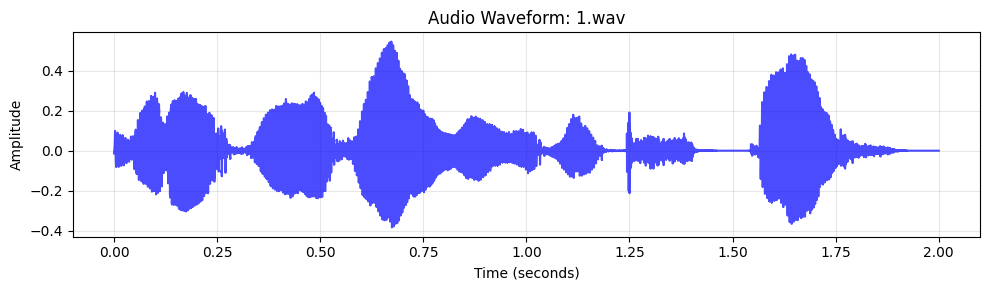

Audio Player:



──────────────────────────────────────────────────
AUDIO FILE 2: 2.wav
──────────────────────────────────────────────────
File Info:
    Duration: 6.99 seconds
    Sample rate: 22050 Hz
    Channels: 1
    File size: 451.5 KB
Text: Туңгуч велосипедди  ар кайсы өлкөлөрдүн  ойлоп чыгаруучулары жасашкан.


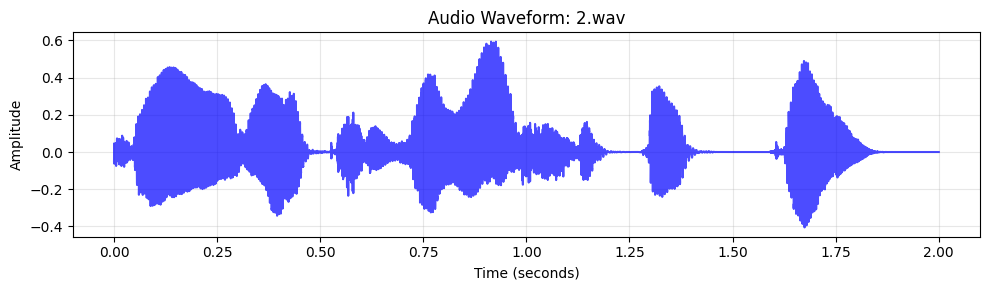

Audio Player:



──────────────────────────────────────────────────
AUDIO FILE 3: 3.wav
──────────────────────────────────────────────────
File Info:
    Duration: 11.05 seconds
    Sample rate: 22050 Hz
    Channels: 1
    File size: 714.0 KB
Text: Алдыңкы дөңгөлөгү  чоң, арткы дөңгөлөгү кичине болгон, эң алгачкы педалдуу велосипедди орус мастери ...


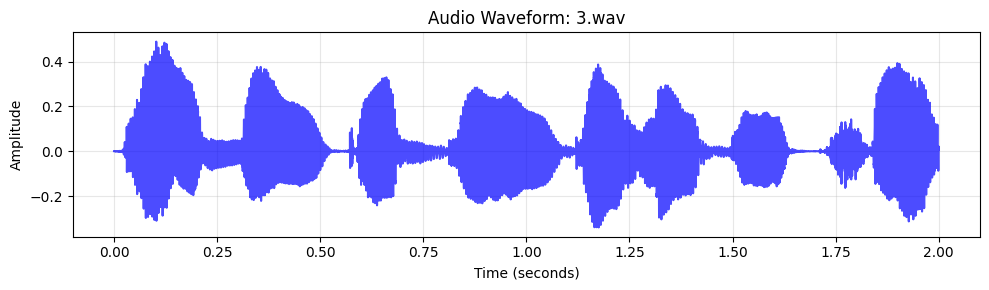

Audio Player:



Audio demonstration completed!

AUDIO QUALITY ANALYSIS
Statistics for 1569 audio files:
   Average duration: 12.38 seconds
   Duration range: 3.45s - 58.43s
   Total audio duration: 323.82 minutes
   Average file size: 800.0 KB
   Total storage used: 1225.77 MB


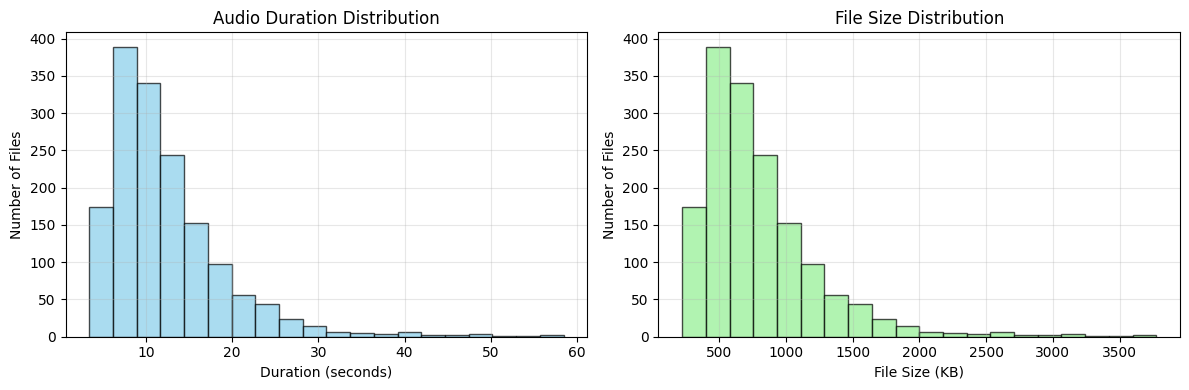

In [3]:
# Audio Demonstration Section
def demonstrate_audio_files(audio_dir="audio_files", num_to_show=5):
    """Display and play sample audio files with analysis"""
    
    print("\n" + "="*60)
    print("AUDIO FILES DEMONSTRATION")
    print("="*60)
    
    # Get list of audio files
    audio_files = list(Path(audio_dir).glob("*.wav"))
    audio_files.sort(key=lambda x: int(x.stem))
    
    # Read the text file to show corresponding texts
    with open("texts.txt", 'r', encoding='utf-8') as f:
        text_lines = f.readlines()
    
    print(f"Found {len(audio_files)} audio files")
    print(f"Showing first {min(num_to_show, len(audio_files))} files for demonstration\n")
    
    for i, audio_file in enumerate(audio_files[:num_to_show]):
        print(f"\n{'─'*50}")
        print(f"AUDIO FILE {i+1}: {audio_file.name}")
        print(f"{'─'*50}")
        
        try:
            # Load audio data
            audio_data, sample_rate = sf.read(str(audio_file))
            duration = len(audio_data) / sample_rate
            
            # Display file information
            print(f"File Info:")
            print(f"    Duration: {duration:.2f} seconds")
            print(f"    Sample rate: {sample_rate} Hz")
            print(f"    Channels: {audio_data.shape[1] if len(audio_data.shape) > 1 else 1}")
            print(f"    File size: {os.path.getsize(audio_file) / 1024:.1f} KB")
            
            # Display corresponding text
            if i < len(text_lines):
                text_preview = text_lines[i].strip()
                # Truncate long texts for display
                if len(text_preview) > 100:
                    text_preview = text_preview[:100] + "..."
                print(f"Text: {text_preview}")
            
            # Create a simple waveform visualization
            plt.figure(figsize=(10, 3))
            
            # Handle both mono and stereo audio
            if len(audio_data.shape) > 1:
                audio_mono = audio_data.mean(axis=1)
            else:
                audio_mono = audio_data
            
            # Plot first 2 seconds or entire audio if shorter
            samples_to_plot = min(len(audio_mono), int(2 * sample_rate))
            time_axis = np.linspace(0, samples_to_plot/sample_rate, samples_to_plot)
            
            plt.plot(time_axis, audio_mono[:samples_to_plot], color='blue', alpha=0.7)
            plt.title(f'Audio Waveform: {audio_file.name}')
            plt.xlabel('Time (seconds)')
            plt.ylabel('Amplitude')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Display audio player
            print("Audio Player:")
            display(Audio(str(audio_file)))
            
            # Add small delay between files for better presentation
            time.sleep(0.5)
            
        except Exception as e:
            print(f"Error displaying {audio_file.name}: {e}")
    
    print(f"\n{'='*60}")
    print("Audio demonstration completed!")
    print(f"{'='*60}")

def analyze_audio_quality(audio_dir="audio_files"):
    """Analyze the quality and characteristics of generated audio files"""
    
    print("\n" + "="*60)
    print("AUDIO QUALITY ANALYSIS")
    print("="*60)
    
    audio_files = list(Path(audio_dir).glob("*.wav"))
    
    if not audio_files:
        print("No audio files found for analysis")
        return
    
    durations = []
    file_sizes = []
    
    for audio_file in audio_files:
        try:
            audio_data, sample_rate = sf.read(str(audio_file))
            duration = len(audio_data) / sample_rate
            file_size = os.path.getsize(audio_file) / 1024  # KB
            
            durations.append(duration)
            file_sizes.append(file_size)
            
        except Exception as e:
            print(f"Error analyzing {audio_file.name}: {e}")
    
    if durations:
        print(f"Statistics for {len(durations)} audio files:")
        print(f"   Average duration: {np.mean(durations):.2f} seconds")
        print(f"   Duration range: {min(durations):.2f}s - {max(durations):.2f}s")
        print(f"   Total audio duration: {sum(durations)/60:.2f} minutes")
        print(f"   Average file size: {np.mean(file_sizes):.1f} KB")
        print(f"   Total storage used: {sum(file_sizes)/1024:.2f} MB")
        
        # Create summary plot
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(durations, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.xlabel('Duration (seconds)')
        plt.ylabel('Number of Files')
        plt.title('Audio Duration Distribution')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.hist(file_sizes, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
        plt.xlabel('File Size (KB)')
        plt.ylabel('Number of Files')
        plt.title('File Size Distribution')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Run the demonstration
print("Starting audio demonstration...")

demonstrate_audio_files(num_to_show=3) 

analyze_audio_quality()


#### Create archive file

In [4]:
def create_archive():
    archive_name = "bvt2201_nyathi_17_matcha_kyrgyz.tar.gz"
    
    print("\n" + "="*60)
    print("CREATING FINAL ARCHIVE")
    print("="*60)
    
    with tarfile.open(archive_name, "w:gz") as tar:
        # Add text file
        if os.path.exists("texts.txt"):
            tar.add("texts.txt")
            print("Added texts.txt")
        
        # Add audio files
        audio_dir = "audio_files"
        if os.path.exists(audio_dir):
            audio_files = list(Path(audio_dir).glob("*.wav"))
            for audio_file in audio_files:
                tar.add(audio_file)
            print(f"Added {len(audio_files)} audio files")
    
    # Check archive size and contents
    archive_size = os.path.getsize(archive_name) / 1024  # Size in KB
    print(f"\n Archive created successfully!")
    print(f"   Archive name: {archive_name}")
    print(f"   Archive size: {archive_size:.2f} KB")
    
    # Show archive contents
    with tarfile.open(archive_name, "r:gz") as tar:
        members = tar.getnames()
        text_files = [f for f in members if f.endswith('.txt')]
        audio_files = [f for f in members if f.endswith('.wav')]
        
        print(f"   Text files: {len(text_files)}")
        print(f"   Audio files: {len(audio_files)}")
        print(f"   First 5 files: {members[:5]}")
    
    return archive_name

# Create the archive
archive_path = create_archive()

print(f"Archive file: {archive_path}")


CREATING FINAL ARCHIVE
Added texts.txt
Added 1570 audio files

 Archive created successfully!
   Archive name: bvt2201_nyathi_17_matcha_kyrgyz.tar.gz
   Archive size: 1136971.97 KB
   Text files: 1
   Audio files: 1570
   First 5 files: ['texts.txt', 'audio_files/1477.wav', 'audio_files/1038.wav', 'audio_files/215.wav', 'audio_files/1205.wav']
Archive file: bvt2201_nyathi_17_matcha_kyrgyz.tar.gz
